---

**This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.**

---

Welcome to the **2025 Lawrence Livermore National Laboratory Data Science Challenge!**

Launch Presentation consists of:
- (1) High-Level overview **(Short Slidedeck)** of current state-of-the-art methods for a variety of tasks
- (2) High-Level overview **(Dataset Card)** of MOVi-MC-AC
- (3) High-Level overview of **(OneDrive Folder)** of DSC Target Dataset: <u>**Robotics Laboratory Pick and Place Dataset**</u>


- (4) Low-Level example **(Jupyter Notebook)** of using state-of-the-art methods (SAM2) on DSC Target Dataset


- (5) Low-Level overview **(Jupyter Notebook)** of MOVi-MC-AC + DSC Tasks

**This notebook serves as the technical introduction to LLNL's MOVi-MC-AC Dataset (last bullet above), covering**:
- (1) Introduction to Image Processing / Computer Vision
- (2) Example Baseline Experiment
- (3) DSC Challenge & Tasking
  - **Task 1.1**: (Image-based) Modal Mask -> Amodal Mask
  - **Task 1.2**: (Image-based) Modal Content (RGB) -> Amodal Content (RGB)
  - **Task 2.1**: (Video-based) Modal Mask -> Amodal Mask
  - **Task 2.2**: (Video-based) Modal Content (RGB) -> Amodal Content (RGB)
  - **Transfer Test**: Apply Models on DSC Target Dataset:
    - Gather Modal Masks from some SotA method (SAM2)
    - Predict Amodal Masks, using Modal Masks
  - **Bonus Task 3**: Create Modal Masks with SAM2
  - **Bonus Task 4**: Re-ID of Objects

# Introduction to Image Processing / Computer Vision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports & Util Functions

In [ ]:
pip install torch torchvision matplotlib av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

> Uncomment the above cell to install necessary libraries!

In [ ]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

# Example Baseline Experiment

Let's train a model from scratch to do something interesting!

> "Given an RGB image of a scene, let's predict all object masks, as a single class."

### Example Inputs & Outputs

In [ ]:
sample_dir = 'ff5da6d6ecae486bb294aeaf5ee8f8a1/'

In [ ]:
sample_dir = Path(sample_dir)
list(sample_dir.iterdir())

[PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0004'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0003'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0002')]

In [ ]:
sample_dict = get_sample_dict(sample_dir)
sample_dict['camera_0000'].keys()

dict_keys(['scene', 'obj_0001', 'obj_0002', 'obj_0003', 'obj_0004', 'obj_0005', 'obj_0006', 'obj_0007', 'obj_0008', 'obj_0009', 'obj_0010', 'obj_0011', 'obj_0012', 'obj_0013', 'obj_0014', 'obj_0015', 'obj_0016', 'obj_0017', 'obj_0018', 'obj_0019'])

Example Model Input:
- Tensor of shape (C H W)
- RGB values are within the [0, 1] range

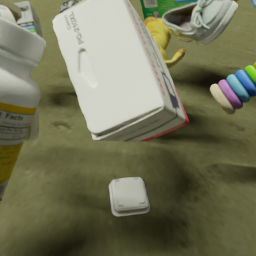

In [ ]:
scene_img = Image.open(sample_dict['camera_0000']['scene']['rgba'][0]).convert('RGB')
scene_img

In [ ]:
input_tensor = image_to_tensor(scene_img)
input_tensor.shape, input_tensor.min(), input_tensor.max()

(torch.Size([3, 256, 256]), tensor(0.0078), tensor(0.8902))

Example Model Output:
- Tensor of shape (C W)
- Binary values (0 for no object, 1 for object)

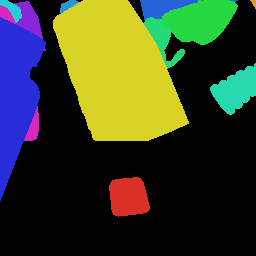

In [ ]:
obj_masks = Image.open(sample_dict['camera_0000']['scene']['segmentation'][0])
obj_masks

array([[11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
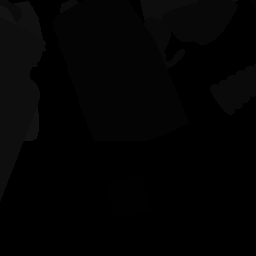

In [ ]:
np.array(obj_masks)

In [ ]:
output_tensor = torch.tensor(np.array(obj_masks))
output_tensor.shape, output_tensor.min(), output_tensor.max()

(torch.Size([256, 256]),
 tensor(0, dtype=torch.uint8),
 tensor(18, dtype=torch.uint8))

In [ ]:
output_tensor = (output_tensor != 0).float()
output_tensor.shape, output_tensor.min(), output_tensor.max()

(torch.Size([256, 256]), tensor(0.), tensor(1.))

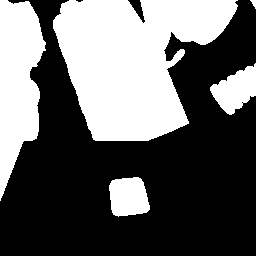

In [ ]:
tensor_to_image(output_tensor)

### PyTorch Dataset

PyTorch!
- https://docs.pytorch.org/tutorials/beginner/basics/intro.html
- https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

For simplicitly, we are working with just one sample folder!
- Feel free to extend this dataset to allow a "root directory" that contains multiple sample folders!

Some other important dataset design considerations:
- Train/test splits
- Deterministic behavior (for visualization purposes)

In [ ]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, sample_dir):
        sample_dir = Path(sample_dir)
        self.sample_dict = get_sample_dict(sample_dir)
        self.num_frames = 24
        self.num_cams = 6

    def __len__(self):
        # Total number of unique scene images
        return self.num_frames * self.num_cams

    def __getitem__(self, idx):
        rand_cam_idx = random.randint(0, self.num_cams-1)
        rand_frame_idx = random.randint(0, self.num_frames-1)

        scene_img = Image.open(sample_dict[f'camera_{rand_cam_idx:04d}']['scene']['rgba'][rand_frame_idx]).convert('RGB')
        obj_masks = Image.open(sample_dict[f'camera_{rand_cam_idx:04d}']['scene']['segmentation'][rand_frame_idx])

        scene = image_to_tensor(scene_img)
        mask = (torch.tensor(np.array(obj_masks)) != 0).float()

        return scene, mask

In [ ]:
my_dataset = SimpleDataset('ff5da6d6ecae486bb294aeaf5ee8f8a1')
len(my_dataset)

144

In [ ]:
scene, mask = my_dataset[0]
scene.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

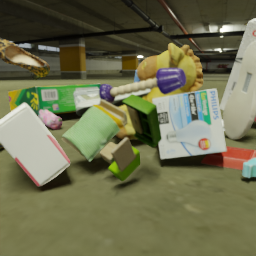

In [ ]:
tensor_to_image(scene)

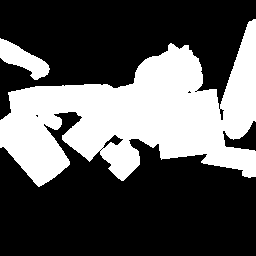

In [ ]:
tensor_to_image(mask)

In [ ]:
from torch.utils.data import DataLoader

my_dataloader = DataLoader(my_dataset, batch_size=4)

In [ ]:
input_batch, target_batch = next(iter(my_dataloader))
input_batch.shape, target_batch.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

### Model

PyTorch's `nn` module is commonly used to build various neural networks (deep learning models)!

We'll start with a simple convolutional layer:
- 2 dimensions: *height + weight*
- 3 input channels: *rgb*
- Input batch shape: (bs, c, h, w)
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3)
conv1

Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))

In [ ]:
input_batch.shape

torch.Size([4, 3, 256, 256])

In [ ]:
conv1_output = conv1(input_batch)
conv1_output.shape, conv1_output.min(), conv1_output.max()

(torch.Size([4, 32, 256, 256]),
 tensor(-1.4236, grad_fn=<MinBackward1>),
 tensor(0.9990, grad_fn=<MaxBackward1>))

Neural networks are composed of:
- linear operations (matrix multiplications, `nn.Linear` & `nn.Conv` are actually just matmuls!)
- non-linearity operations (`nn.Relu` - *all negative numbers become 0*)
  - https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [ ]:
relu1 = nn.ReLU()
relu1_output = relu1(conv1_output)
relu1_output.shape, relu1_output.min(), relu1_output.max()

(torch.Size([4, 32, 256, 256]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(0.9990, grad_fn=<MaxBackward1>))

We can compose these to make a "deeper" model!

Remember:
- our input is a 3-channel image
- our target should be a binary mask (e.g. 1 channel)

In [ ]:
class SimpleConv2DModel(nn.Module):

    def __init__(self):
        super(SimpleConv2DModel, self).__init__()
        # Define multiple Conv2D layers with 'same' padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.final_conv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.final_conv(x)

        return x

In [ ]:
my_model = SimpleConv2DModel()
my_model

SimpleConv2DModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
input_batch, target_batch = next(iter(my_dataloader))
input_batch.shape, target_batch.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

Let's visualize an input and output target!

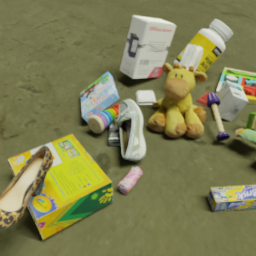

In [ ]:
tensor_to_image(input_batch[0])

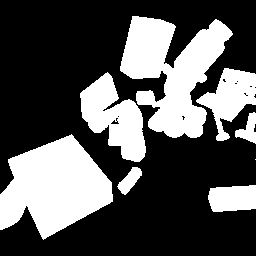

In [ ]:
tensor_to_image(target_batch[0])

In [ ]:
logits = my_model(input_batch)
logits.shape

torch.Size([4, 1, 256, 256])

Outputs should be close to 0 and 1, can use sigmoid!
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

We didn't use a 3rd ReLU since our last non-linearaity will be a simgoid, otherwise it wouldn't be possible to predict values close to 0!
- (All the negative numbers turn to 0, and 0 into a sigmoid is 0.5!)

In [ ]:
logits.min(), logits.max()

(tensor(-0.1115, grad_fn=<MinBackward1>),
 tensor(-0.0301, grad_fn=<MaxBackward1>))

In [ ]:
preds = torch.sigmoid(logits)
preds.min(), preds.max()

(tensor(0.4721, grad_fn=<MinBackward1>),
 tensor(0.4925, grad_fn=<MaxBackward1>))

In [ ]:
rounded_preds = torch.round(preds)
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(0., grad_fn=<MaxBackward1>))

Let's visualize the model outputs!

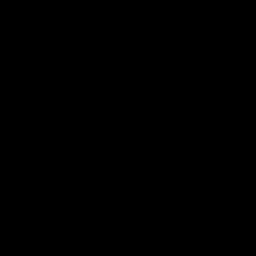

In [ ]:
tensor_to_image(rounded_preds[0])

### Training

Now that we have a model that's able to provide outputs in the correct shape, we'll need a loss function:
- https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

Note that BCEWithLogitsLoss takes in the logits directly, sigmoid is applied within the loss function for you!

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
logits.shape, target_batch.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

In [ ]:
target_batch.unsqueeze(1).shape

torch.Size([4, 1, 256, 256])

In [ ]:
loss = loss_fn(logits, target_batch.unsqueeze(1))
loss

tensor(0.6835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

With a loss function, we're now able to apply an optimizer on loss values to *train* our neural network!

In [ ]:
optimizer = torch.optim.Adam(my_model.parameters(), lr=3e-3)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

Let's take a single "step" and see if the loss improves (on the same sample)!

In [ ]:
loss

tensor(0.6835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
logits = my_model(input_batch)
loss = loss_fn(logits, target_batch.unsqueeze(1))
loss

tensor(0.6752, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

How about 10 more steps?

In [ ]:
for i in range(10):
    logits = my_model(input_batch)
    loss = loss_fn(logits, target_batch.unsqueeze(1))
    print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.6752, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6561, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6410, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6246, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6024, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5750, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


This is a training loop! Some things to add:
- Use different batches
- Learning rate schedulers
- Batch size
- Metrics besides loss

It's important to split your data, and have a separate validation loop to ensure your model can transfer to new data unseen by the model during training
- Validation Dataloader (new videos, and even new objects)
- Metrics besides loss (don't compute loss / take optimization steps in the validation loop, otherwise your model will learn on your validation data!)

### Inference

Let's step 100 more times so the model learns a bit more (on this particular batch of data, possibly overfitting)

In [ ]:
for i in range(100):
    logits = my_model(input_batch)
    loss = loss_fn(logits, target_batch.unsqueeze(1))
    print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.4613, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4428, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4224, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4062, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3930, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3798, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3634, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3535, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3417, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3308, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3203, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3116, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3008, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2935, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2853, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2768, grad_fn=<BinaryCrossEntro

Let's visualize the data & model outputs!

In [ ]:
rounded_preds = logits.sigmoid().round()
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

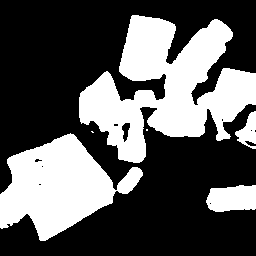

In [ ]:
tensor_to_image(rounded_preds[0])

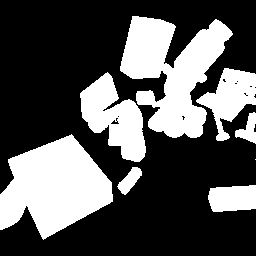

In [ ]:
tensor_to_image(target_batch[0])

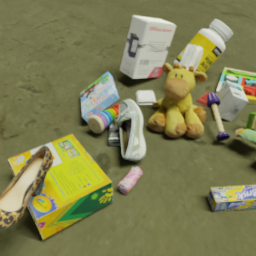

In [ ]:
tensor_to_image(input_batch[0])

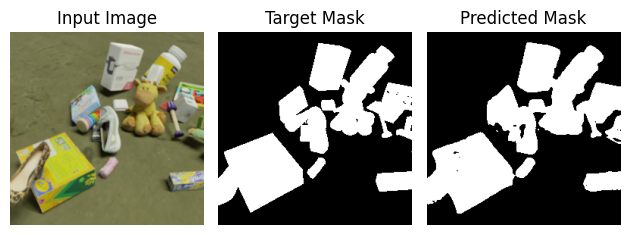

In [ ]:
# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3)

# Plot the images
axes[0].imshow(tensor_to_image(input_batch[0]), cmap='gray')  # First image
axes[0].set_title("Input Image")
axes[0].axis('off')  # Turn off axes

axes[1].imshow(tensor_to_image(target_batch[0]), cmap='gray')  # Second image
axes[1].set_title("Target Mask")
axes[1].axis('off')  # Turn off axes

axes[2].imshow(tensor_to_image(rounded_preds[0]), cmap='gray')  # Third image
axes[2].set_title("Predicted Mask")
axes[2].axis('off')  # Turn off axes

# Adjust layout
plt.tight_layout()
plt.show()

How would the model perform on a new batch of data?

In [ ]:
input_batch, target_batch = next(iter(my_dataloader))

In [ ]:
with torch.no_grad():
    logits = my_model(input_batch)

rounded_preds = logits.sigmoid().round()
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]), tensor(0.), tensor(1.))

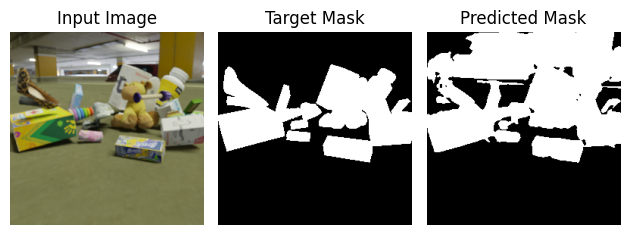

In [ ]:
# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3)

# Plot the images
axes[0].imshow(tensor_to_image(input_batch[0]), cmap='gray')  # First image
axes[0].set_title("Input Image")
axes[0].axis('off')  # Turn off axes

axes[1].imshow(tensor_to_image(target_batch[0]), cmap='gray')  # Second image
axes[1].set_title("Target Mask")
axes[1].axis('off')  # Turn off axes

axes[2].imshow(tensor_to_image(rounded_preds[0]), cmap='gray')  # Third image
axes[2].set_title("Predicted Mask")
axes[2].axis('off')  # Turn off axes

# Adjust layout
plt.tight_layout()
plt.show()

How can we say "how much" it got correctly?

In [ ]:
rounded_preds.shape, target_batch.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

In [ ]:
rounded_preds.shape, target_batch.unsqueeze(1).shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256]))

This will set each "pixel" to be True if the output integer matches the target integer, e.g.
- 0 == 0
- 1 == 1

Be sure to check the shapes are the same before doing these comparison operations!

In [ ]:
is_same = (rounded_preds == target_batch.unsqueeze(1))
is_same

tensor([[[[ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ..., False,  True,  True],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[ True,  True,  True,  ...,  True,  True,  True],
          [ True, False, False,  ...,  True,  True,  True],
          [False, False, False,  ..., False, False,  True],
          ...,
          [ True,  True,  True,  ...,  True,  T

White is "correct"
- We can quantify this by taking the total correct (i.e. 1) divided by the total amount of values!
- Total correct is just the sum of all the Trues
- Total amount is `numel` (<u>**num**</u>ber of <u>**el**</u>ements)

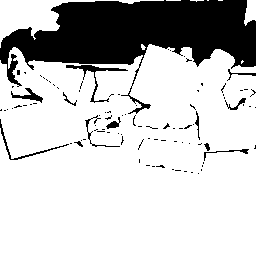

In [ ]:
tensor_to_image(is_same[0].float())

In [ ]:
print('Total Correct:', is_same.sum())
print('Total Amount:', is_same.numel())
print('Overall Accuracy:', is_same.sum() / is_same.numel())

Total Correct: tensor(227310)
Total Amount: 262144
Overall Accuracy: tensor(0.8671)


Note that this is the **Overall Accuracy**, i.e. the accuracy of both classes (class 0 "no object" + class 1 "is object")

To count how many "is_object" pixels it got correct, we can do a similar calculation, except we focus only on the "1" labels.

In [ ]:
# True * True -> True
# True * False -> False
# False * True -> False
# False * False -> False

# -- This last case was previously "False == False -> True"!

# Boolean logic can allow us to "ignore" the 0 class

# You can technically write a loop to go over each pixel for each sample and check:
# -- "is predicted pixel == 1"
# -- "is target pixel == 1"
# "If so, total_count += 1"

# This will be incredibly slow to loop over each value, matrix operations are super fast, use them when possible!

is_same_1s = (rounded_preds==1) * (target_batch.unsqueeze(1)==1)
is_same_1s

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fa

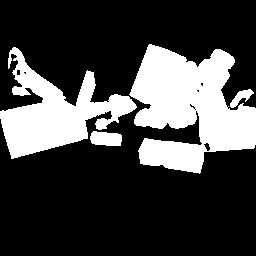

In [ ]:
tensor_to_image(is_same_1s[0].float())

In [ ]:
is_same_1s.sum(), (target_batch==1).sum(), is_same_1s.sum() / (target_batch==1).sum()

(tensor(87191), tensor(91950), tensor(0.9482))

In [ ]:
print('Total Correct:', is_same_1s.sum())
print('Total Amount:', (target_batch==1).sum())
print('"is_object" Class Accuracy:', is_same_1s.sum() / (target_batch==1).sum())

Total Correct: tensor(87191)
Total Amount: tensor(91950)
"is_object" Class Accuracy: tensor(0.9482)


When focusing on just the "is_object" class, the accuracy is much lower than the Overall Accuracy! Why? Class imbalance!
- There are much more "background"/"no_object" pixels!

# 2025 DSC Tasks

Below are 4 tasks!

The goal here is to
- (1) First train models to solve the 4 tasks *quantiatively*
- (2) *Qualitatively* evaluate your trained models on real-world data, specifically on the <u>**Robotics Laboratory Pick and Place Dataset**</u>!

---

### Task 1.1: (Image-based) Modal Mask -> Amodal Mask

> "Given an image of the modal mask of an object, predict the amodal mask of the same object"

Inputs:
- RGB Frame
  - 3-channel image (3, 256, 256)
- Modal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)

Outputs:
- Amodal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)

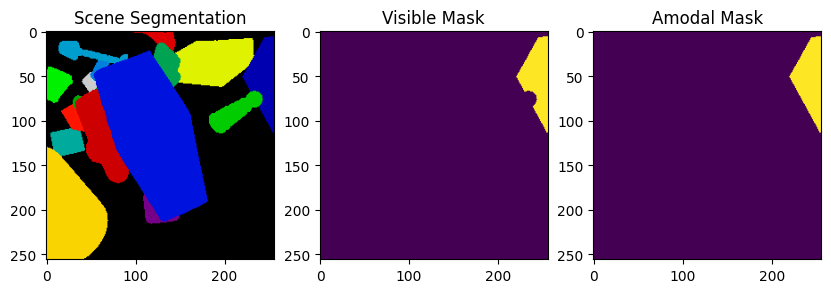

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

#base paths
base_dir = "/content/drive/MyDrive/colab_data/ff5da6d6ecae486bb294aeaf5ee8f8a1"
camera_id = "camera_0000"
image_idx = 5  #frames 0-23
obj_id = "obj_0003"

#to parse through file paths
scene_seg_path = os.path.join(base_dir, camera_id, f"segmentation_{image_idx:05d}.png")
object_mask_path = os.path.join(base_dir, camera_id, obj_id, f"segmentation_{image_idx:05d}.png")

#loads scene as a numpy array, and this tells us what pixels belong to what object using integer id's (also single channel)
scene_seg = np.array(Image.open(scene_seg_path))

#just in case image loads as RGB, we take it as one channel and gives us a 2-D map
if scene_seg.ndim == 3:
    scene_seg = scene_seg[:, :, 0]

#loads binary mask
obj_mask = np.array(Image.open(object_mask_path))
if obj_mask.ndim == 3:
    obj_mask = obj_mask[:, :, 0]

#this line uses the objects mask to grab the pixel values to see where it exists in the scene
obj_pixels = scene_seg[obj_mask > 0]

unique_labels, counts = np.unique(obj_pixels, return_counts=True)
object_label_id = unique_labels[np.argmax(counts)]

#creates binary mask for pixels that match object id (i.e. what we can see of the object including obscurity)
visible_mask = (scene_seg == object_label_id).astype(np.uint8)

#creates amodal mask that represents entire object regardless of obscurity (also has it in binary)
amodal_mask = (obj_mask > 0).astype(np.uint8)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1); plt.imshow(scene_seg, cmap='nipy_spectral'); plt.title("Scene Segmentation")
plt.subplot(1, 3, 2); plt.imshow(visible_mask); plt.title("Visible Mask")
plt.subplot(1, 3, 3); plt.imshow(amodal_mask); plt.title("Amodal Mask")
plt.show()

In [ ]:
!pip install torch torchvision matplotlib opencv-python

Using device: cuda
Dataset splits:
Training set size: 1915 (70.0%)
Validation set size: 410 (15.0%)
Test set size: 411 (15.0%)


Epoch 1/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.6008]



Epoch 1/10:
Training Loss: 0.6359
Validation Loss: 0.5911
--------------------------------------------------
Saving best model with validation loss: 0.5911


Epoch 2/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s, loss=0.5510]



Epoch 2/10:
Training Loss: 0.5659
Validation Loss: 0.5397
--------------------------------------------------
Saving best model with validation loss: 0.5397


Epoch 3/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.4929]



Epoch 3/10:
Training Loss: 0.5133
Validation Loss: 0.4798
--------------------------------------------------
Saving best model with validation loss: 0.4798


Epoch 4/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s, loss=0.4460]



Epoch 4/10:
Training Loss: 0.4676
Validation Loss: 0.4334
--------------------------------------------------
Saving best model with validation loss: 0.4334


Epoch 5/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.4190]



Epoch 5/10:
Training Loss: 0.4254
Validation Loss: 0.4066
--------------------------------------------------
Saving best model with validation loss: 0.4066


Epoch 6/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.3622]



Epoch 6/10:
Training Loss: 0.3832
Validation Loss: 0.3481
--------------------------------------------------
Saving best model with validation loss: 0.3481


Epoch 7/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.3290]



Epoch 7/10:
Training Loss: 0.3398
Validation Loss: 0.3145
--------------------------------------------------
Saving best model with validation loss: 0.3145


Epoch 8/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.2751]



Epoch 8/10:
Training Loss: 0.2973
Validation Loss: 0.2615
--------------------------------------------------
Saving best model with validation loss: 0.2615


Epoch 9/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s, loss=0.2378]



Epoch 9/10:
Training Loss: 0.2577
Validation Loss: 0.2305
--------------------------------------------------
Saving best model with validation loss: 0.2305


Epoch 10/10 [Val]: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.2213]



Epoch 10/10:
Training Loss: 0.2235
Validation Loss: 0.2129
--------------------------------------------------
Saving best model with validation loss: 0.2129


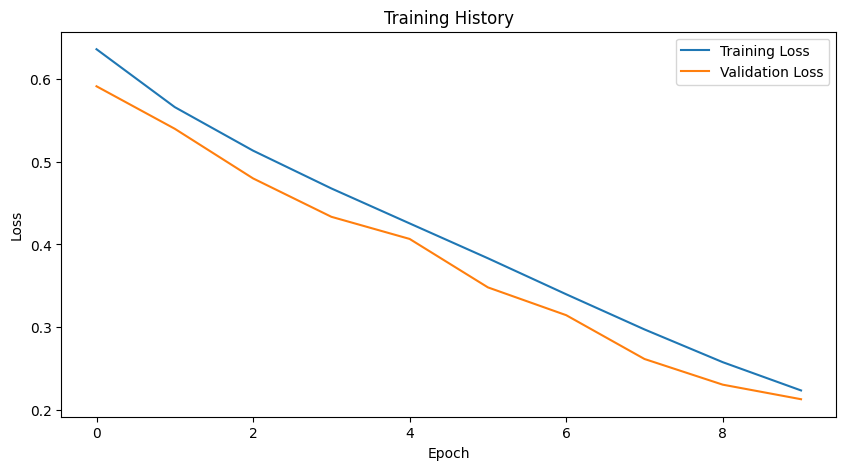


Evaluating model on test set...


Testing: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.2493]


Test Loss: 0.2298

Visualizing results on test set...


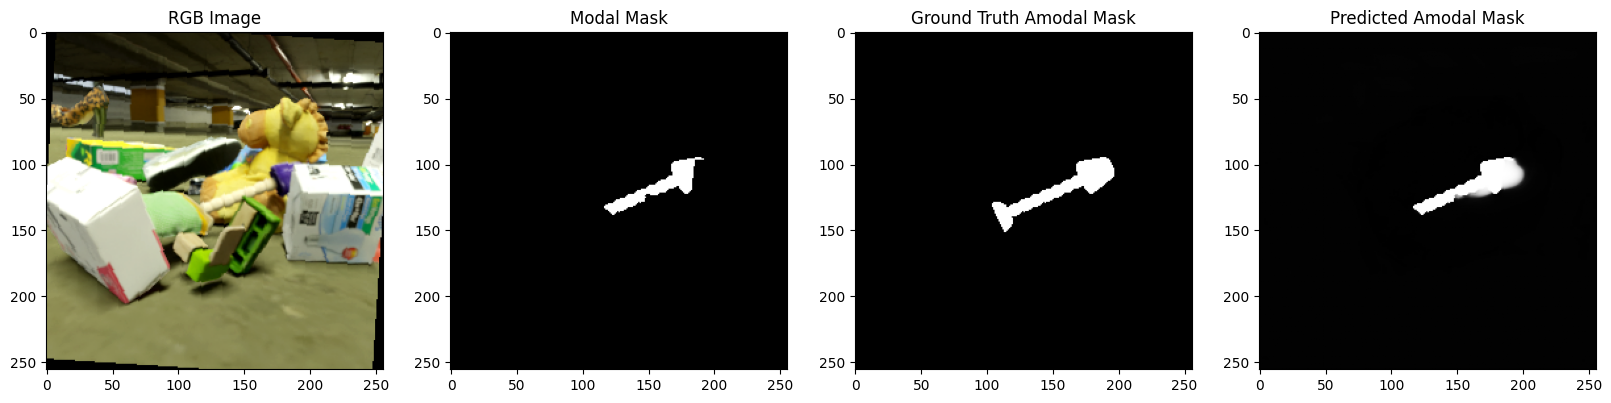

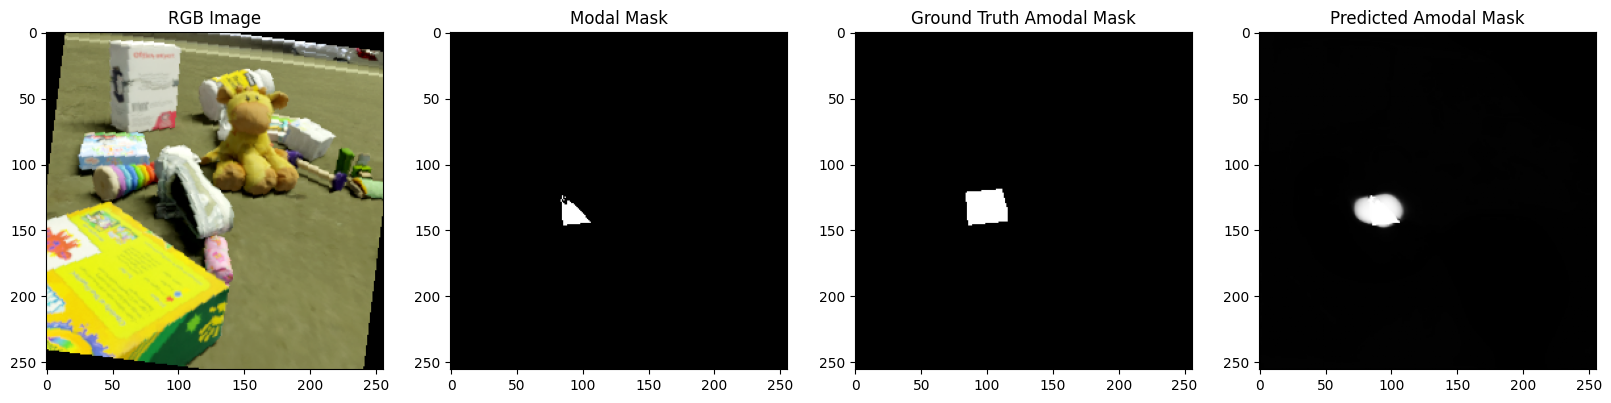

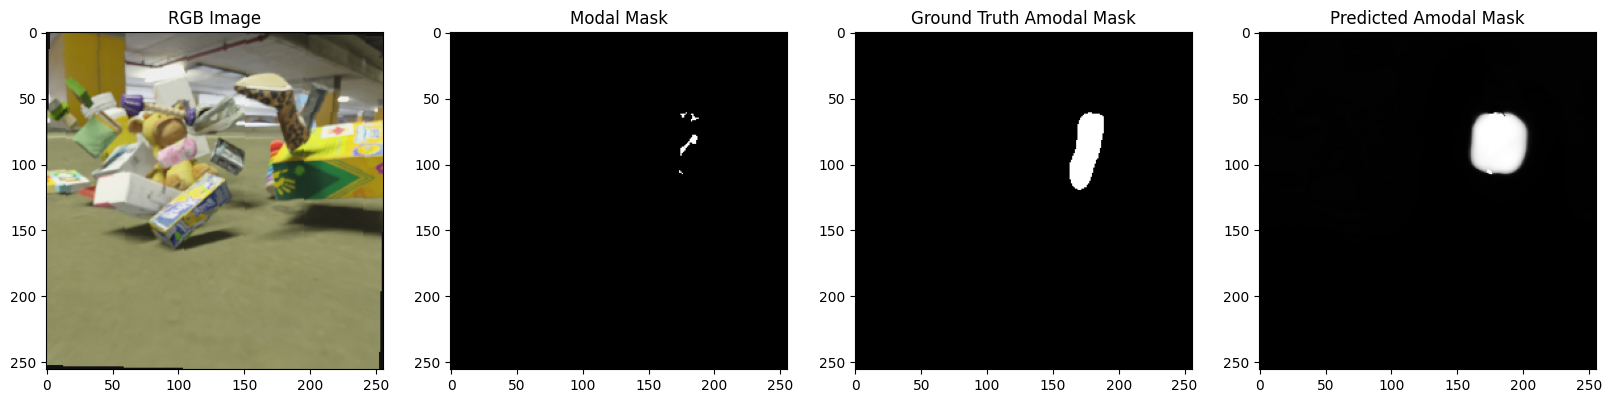

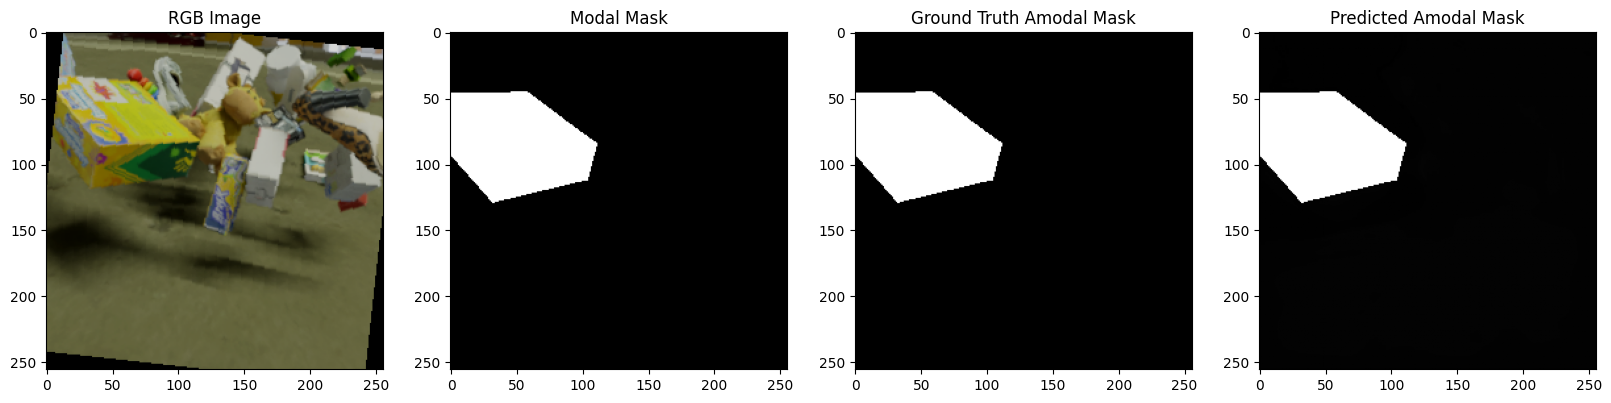

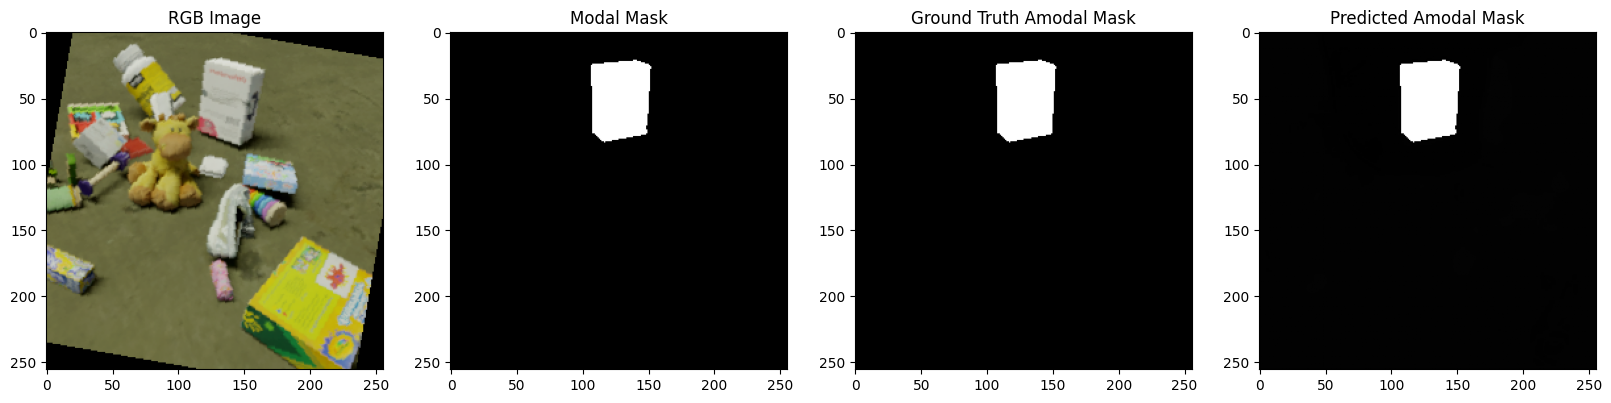

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Custom loss function
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, pred, target):
        smooth = 1e-5
        intersection = (pred * target).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

# Dataset Class
class ModalAmodalDataset(Dataset):
    def __init__(self, root_dir, transform=None, camera_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Get all camera folders or use specified ones
        if camera_folders is None:
            camera_folders = [f for f in os.listdir(root_dir) if f.startswith('camera_')]

        for camera_folder in camera_folders:
            camera_path = os.path.join(root_dir, camera_folder)

            # Get base RGB images and segmentation masks
            base_rgb_files = sorted([f for f in os.listdir(camera_path) if f.startswith('rgba_')])
            base_seg_files = sorted([f for f in os.listdir(camera_path) if f.startswith('segmentation_')])

            # Get object folders
            obj_folders = sorted([f for f in os.listdir(camera_path) if f.startswith('obj_')])

            for frame_idx in range(len(base_rgb_files)):
                rgb_file = base_rgb_files[frame_idx]
                frame_number = rgb_file.split('_')[1].split('.')[0]

                for obj_folder in obj_folders:
                    obj_id = int(obj_folder.split('_')[1])
                    obj_path = os.path.join(camera_path, obj_folder)
                    obj_seg_file = f'segmentation_{frame_number}.png'

                    if os.path.exists(os.path.join(obj_path, obj_seg_file)):
                        self.samples.append({
                            'rgb_path': os.path.join(camera_path, rgb_file),
                            'modal_mask_path': os.path.join(camera_path, base_seg_files[frame_idx]),
                            'amodal_mask_path': os.path.join(obj_path, obj_seg_file),
                            'object_id': obj_id,
                            'frame_id': frame_number,
                            'camera': camera_folder
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load RGB image
        rgb_img = Image.open(sample['rgb_path']).convert('RGB')

        # Load and process modal mask
        modal_seg = Image.open(sample['modal_mask_path'])
        modal_array = np.array(modal_seg)

        # Create binary mask for specific object
        modal_mask = (modal_array == sample['object_id']).astype(np.uint8)
        modal_mask = Image.fromarray(modal_mask * 255)

        # Load amodal mask and convert to binary
        amodal_mask = Image.open(sample['amodal_mask_path']).convert('L')
        amodal_array = np.array(amodal_mask)
        amodal_mask = Image.fromarray((amodal_array > 0).astype(np.uint8) * 255)

        # Apply transforms
        if self.transform:
            rgb_img = self.transform(rgb_img)
            modal_mask = transforms.ToTensor()(modal_mask.resize((256, 256)))
            amodal_mask = transforms.ToTensor()(amodal_mask.resize((256, 256)))
        else:
            rgb_img = transforms.ToTensor()(rgb_img)
            modal_mask = transforms.ToTensor()(modal_mask)
            amodal_mask = transforms.ToTensor()(amodal_mask)

        # Ensure masks are binary
        modal_mask = (modal_mask > 0.5).float()
        amodal_mask = (amodal_mask > 0.5).float()

        return {
            'rgb': rgb_img,
            'modal_mask': modal_mask,
            'amodal_mask': amodal_mask,
            'object_id': sample['object_id'],
            'frame_id': sample['frame_id'],
            'camera': sample['camera']
        }

# Enhanced U-Net architecture
class EnhancedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = self._make_layer(4, 64)    # 4 channels: 3 RGB + 1 modal mask
        self.enc2 = self._make_layer(64, 128)
        self.enc3 = self._make_layer(128, 256)
        self.enc4 = self._make_layer(256, 512)
        self.enc5 = self._make_layer(512, 1024)

        # Decoder
        self.dec4 = self._make_layer(1024 + 512, 512)
        self.dec3 = self._make_layer(512 + 256, 256)
        self.dec2 = self._make_layer(256 + 128, 128)
        self.dec1 = self._make_layer(128 + 64, 64)

        # Final layers
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), #call this command again and convert it
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout2d(0.5)
        self.pool = nn.MaxPool2d(2)

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        # Apply dropout
        e5 = self.dropout(e5)

        # Decoder with skip connections
        d4 = self.dec4(torch.cat([F.interpolate(e5, size=e4.shape[2:], mode='bilinear', align_corners=True), e4], dim=1))
        d3 = self.dec3(torch.cat([F.interpolate(d4, size=e3.shape[2:], mode='bilinear', align_corners=True), e3], dim=1))
        d2 = self.dec2(torch.cat([F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True), e2], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True), e1], dim=1))

        return self.final(d1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch in train_pbar:
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, amodal_mask)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch in val_pbar:
                rgb_img = batch['rgb'].to(device)
                modal_mask = batch['modal_mask'].to(device)
                amodal_mask = batch['amodal_mask'].to(device)

                x = torch.cat([rgb_img, modal_mask], dim=1)
                output = model(x)
                loss = criterion(output, amodal_mask)

                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f'Saving best model with validation loss: {best_val_loss:.4f}')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_model.pth')

    return history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for batch in test_pbar:
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)

            loss = criterion(pred_mask, amodal_mask)
            total_loss += loss.item()

            test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_test_loss = total_loss / len(test_loader)
    print(f'\nTest Loss: {avg_test_loss:.4f}')

    return avg_test_loss

def visualize_results(model, data_loader, device, num_samples=5):
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break

            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)

            # Move to CPU for visualization
            rgb_img = rgb_img.cpu()
            modal_mask = modal_mask.cpu()
            amodal_mask = amodal_mask.cpu()
            pred_mask = pred_mask.cpu()

            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            axes[0].imshow(rgb_img[0].permute(1, 2, 0))
            axes[0].set_title('RGB Image')

            axes[1].imshow(modal_mask[0, 0], cmap='gray')
            axes[1].set_title('Modal Mask')

            axes[2].imshow(amodal_mask[0, 0], cmap='gray')
            axes[2].set_title('Ground Truth Amodal Mask')

            axes[3].imshow(pred_mask[0, 0], cmap='gray')
            axes[3].set_title('Predicted Amodal Mask')

            plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define transforms with augmentation
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])

    # Create full dataset
    dataset_path = '/content/ff5da6d6ecae486bb294aeaf5ee8f8a1'  # Update path
    full_dataset = ModalAmodalDataset(
        root_dir=dataset_path,
        transform=transform
    )

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Dataset splits:")
    print(f"Training set size: {len(train_dataset)} ({len(train_dataset)/total_size:.1%})")
    print(f"Validation set size: {len(val_dataset)} ({len(val_dataset)/total_size:.1%})")
    print(f"Test set size: {len(test_dataset)} ({len(test_dataset)/total_size:.1%})")

    # Initialize model
    model = EnhancedUNet().to(device)

    # Define loss function and optimizer
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        threshold=1e-4

    )

    # Train the model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()

    # Evaluate on test set
    print("\nEvaluating model on test set...")
    test_loss = evaluate_model(model, test_loader, criterion, device)

    # Visualize results
    print("\nVisualizing results on test set...")
    visualize_results(model, test_loader, device)

if __name__ == "__main__":
    main()



In [ ]:
#Add metric functions
def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target = (target > 0.5).float()
    intersection = (pred_bin * target).sum(dim=(1, 2, 3))
    union = ((pred_bin + target) > 0).float().sum(dim=(1, 2, 3))
    return ((intersection + 1e-5) / (union + 1e-5)).mean().item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target = (target > 0.5).float()
    tp = (pred_bin * target).sum(dim=(1, 2, 3))
    fp = (pred_bin * (1 - target)).sum(dim=(1, 2, 3))
    fn = ((1 - pred_bin) * target).sum(dim=(1, 2, 3))
    return ((2 * tp + 1e-5) / (2 * tp + fp + fn + 1e-5)).mean().item()


In [ ]:
#Evaluate_metrics
def evaluate_metrics(model, data_loader, device, threshold=0.5):
    model.eval()
    iou_total, f1_total, n = 0.0, 0.0, 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Metrics"):
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)

            iou_total += compute_iou(pred_mask, amodal_mask, threshold)
            f1_total += compute_f1(pred_mask, amodal_mask, threshold)
            n += 1

    avg_iou = iou_total / n
    avg_f1 = f1_total / n

    print(f"\nAverage IoU:  {avg_iou:.4f}")
    print(f"Average F1:   {avg_f1:.4f}")

    return avg_iou, avg_f1

In [ ]:
# Dataset and transform setup
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Set dataset path
dataset_path = '/content/ff5da6d6ecae486bb294aeaf5ee8f8a1'  # Use same path as before

# Create full dataset
full_dataset = ModalAmodalDataset(root_dir=dataset_path, transform=transform)

# Split again using same seed
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Only need test loader for evaluation
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Re-initialize and load the trained model
model = EnhancedUNet().to(device)
model.load_state_dict(torch.load("best_model.pth")["model_state_dict"])
model.eval()

# Redefine loss function (if not already)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Evaluate on test set
print("\nEvaluating model on test set...")
test_loss = evaluate_model(model, test_loader, criterion, device)

# Compute IoU and F1
print("\nComputing IoU and F1 Score...")
avg_iou, avg_f1 = evaluate_metrics(model, test_loader, device)

# Dataset and transform setup
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Set dataset path
dataset_path = '/content/ff5da6d6ecae486bb294aeaf5ee8f8a1'  # Use same path as before

# Create full dataset
full_dataset = ModalAmodalDataset(root_dir=dataset_path, transform=transform)

# Split again using same seed
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Only need test loader for evaluation
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

---

### Task 1.2: (Image-based) Modal Content (RGB) -> Amodal Content (RGB)

> "Given an image of the modal RGB content of an object, predict the amodal RGB content of the same object"

> "Can use the amodal masks of that object"

Inputs:
- RGB Frame
  - 3-channel image (3, 256, 256)
- Amodal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)
- RGB Content of Object *i*
  - 3-channel image (3, 256, 256)
  - Use the object's modal mask to "crop out" the RGB content of object *i*
  - Optional to use?
  
Outputs:
- Amodal RGB Content of Object *i*
  - 3-channel image (3, 256, 256)

In [ ]:
#need to add a way to get the colors back into the amodal mask
# convert it back into 3 channels from the 1 channel of binary

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Custom loss function
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, pred, target):
        smooth = 1e-5
        intersection = (pred * target).sum(dim=(2,3))
        union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

# Dataset Class
class ModalAmodalDataset(Dataset):
    def __init__(self, root_dir, transform=None, camera_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Get all camera folders or use specified ones
        if camera_folders is None:
            camera_folders = [f for f in os.listdir(root_dir) if f.startswith('camera_')]

        for camera_folder in camera_folders:
            camera_path = os.path.join(root_dir, camera_folder)

            # Get base RGB images and segmentation masks
            base_rgb_files = sorted([f for f in os.listdir(camera_path) if f.startswith('rgba_')])
            base_seg_files = sorted([f for f in os.listdir(camera_path) if f.startswith('segmentation_')])

            # Get object folders
            obj_folders = sorted([f for f in os.listdir(camera_path) if f.startswith('obj_')])

            for frame_idx in range(len(base_rgb_files)):
                rgb_file = base_rgb_files[frame_idx]
                frame_number = rgb_file.split('_')[1].split('.')[0]

                for obj_folder in obj_folders:
                    obj_id = int(obj_folder.split('_')[1])
                    obj_path = os.path.join(camera_path, obj_folder)
                    obj_seg_file = f'segmentation_{frame_number}.png'

                    if os.path.exists(os.path.join(obj_path, obj_seg_file)):
                        self.samples.append({
                            'rgb_path': os.path.join(camera_path, rgb_file),
                            'modal_mask_path': os.path.join(camera_path, base_seg_files[frame_idx]),
                            'amodal_mask_path': os.path.join(obj_path, obj_seg_file),
                            'object_id': obj_id,
                            'frame_id': frame_number,
                            'camera': camera_folder
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load RGB image
        rgb_img = Image.open(sample['rgb_path']).convert('RGB')

        # Load and process modal mask
        modal_seg = Image.open(sample['modal_mask_path'])
        modal_array = np.array(modal_seg)

        # Create binary mask for specific object
        modal_mask = (modal_array == sample['object_id']).astype(np.uint8)
        modal_mask = Image.fromarray(modal_mask * 255)

        # Load amodal mask and convert to binary
        amodal_mask = Image.open(sample['amodal_mask_path']).convert('L')
        amodal_array = np.array(amodal_mask)
        amodal_mask = Image.fromarray((amodal_array > 0).astype(np.uint8) * 255)

        # Apply transforms
        if self.transform:
            rgb_img = self.transform(rgb_img)
            modal_mask = transforms.ToTensor()(modal_mask.resize((256, 256)))
            amodal_mask = transforms.ToTensor()(amodal_mask.resize((256, 256)))
        else:
            rgb_img = transforms.ToTensor()(rgb_img)
            modal_mask = transforms.ToTensor()(modal_mask)
            amodal_mask = transforms.ToTensor()(amodal_mask)

        # Ensure masks are binary
        modal_mask = (modal_mask > 0.5).float()
        amodal_mask = (amodal_mask > 0.5).float()

        return {
            'rgb': rgb_img,
            'modal_mask': modal_mask,
            'amodal_mask': amodal_mask,
            'object_id': sample['object_id'],
            'frame_id': sample['frame_id'],
            'camera': sample['camera']
        }

# Enhanced U-Net architecture
class EnhancedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = self._make_layer(4, 64)    # 4 channels: 3 RGB + 1 modal mask
        self.enc2 = self._make_layer(64, 128)
        self.enc3 = self._make_layer(128, 256)
        self.enc4 = self._make_layer(256, 512)
        self.enc5 = self._make_layer(512, 1024)

        # Decoder
        self.dec4 = self._make_layer(1024 + 512, 512)
        self.dec3 = self._make_layer(512 + 256, 256)
        self.dec2 = self._make_layer(256 + 128, 128)
        self.dec1 = self._make_layer(128 + 64, 64)

        # Final layers
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), #call this command again and convert it
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout2d(0.5)
        self.pool = nn.MaxPool2d(2)

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        # Apply dropout
        e5 = self.dropout(e5)

        # Decoder with skip connections
        d4 = self.dec4(torch.cat([F.interpolate(e5, size=e4.shape[2:], mode='bilinear', align_corners=True), e4], dim=1))
        d3 = self.dec3(torch.cat([F.interpolate(d4, size=e3.shape[2:], mode='bilinear', align_corners=True), e3], dim=1))
        d2 = self.dec2(torch.cat([F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True), e2], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True), e1], dim=1))

        return self.final(d1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch in train_pbar:
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, amodal_mask)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch in val_pbar:
                rgb_img = batch['rgb'].to(device)
                modal_mask = batch['modal_mask'].to(device)
                amodal_mask = batch['amodal_mask'].to(device)

                x = torch.cat([rgb_img, modal_mask], dim=1)
                output = model(x)
                loss = criterion(output, amodal_mask)

                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f'Saving best model with validation loss: {best_val_loss:.4f}')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_model.pth')

    return history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for batch in test_pbar:
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)

            loss = criterion(pred_mask, amodal_mask)
            total_loss += loss.item()

            test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_test_loss = total_loss / len(test_loader)
    print(f'\nTest Loss: {avg_test_loss:.4f}')

    return avg_test_loss

# ------------------------------------------------------------
# Evaluation Metrics: IoU and F1 (Dice Coefficient)
# ------------------------------------------------------------

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > 0.5).float()
    intersection = (pred_bin * target_bin).sum(dim=(1, 2, 3))
    union = ((pred_bin + target_bin) > 0).float().sum(dim=(1, 2, 3))
    return ((intersection + 1e-5) / (union + 1e-5)).mean().item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > 0.5).float()
    tp = (pred_bin * target_bin).sum(dim=(1, 2, 3))
    fp = (pred_bin * (1 - target_bin)).sum(dim=(1, 2, 3))
    fn = ((1 - pred_bin) * target_bin).sum(dim=(1, 2, 3))
    return ((2 * tp + 1e-5) / (2 * tp + fp + fn + 1e-5)).mean().item()

def evaluate_metrics(model, data_loader, device, threshold=0.5):
    model.eval()
    iou_total, f1_total, count = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Metrics"):
            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)
            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)
            iou_total += compute_iou(pred_mask, amodal_mask, threshold)
            f1_total += compute_f1(pred_mask, amodal_mask, threshold)
            count += 1
    avg_iou = iou_total / count
    avg_f1 = f1_total / count
    print(f"\nAverage IoU:  {avg_iou:.4f}")
    print(f"Average F1:   {avg_f1:.4f}")
    return avg_iou, avg_f1

def visualize_results(model, data_loader, device, num_samples=5, save_dir="saved_amodal_masks"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break

            rgb_img = batch['rgb'].to(device)
            modal_mask = batch['modal_mask'].to(device)
            amodal_mask = batch['amodal_mask'].to(device)

            x = torch.cat([rgb_img, modal_mask], dim=1)
            pred_mask = model(x)

            # Save the predicted binary amodal mask
            for j in range(pred_mask.size(0)):
                binary_mask = (pred_mask[j, 0] > 0.5).float().cpu().numpy() * 255
                image = Image.fromarray(binary_mask.astype(np.uint8))
                obj_id = batch['object_id'][j].item()
                frame_id = batch['frame_id'][j]
                camera = batch['camera'][j]
                filename = f"{camera}_obj{obj_id:02d}_frame{frame_id}.png"
                image.save(os.path.join(save_dir, filename))

def restore_color_from_rgba(binary_mask_path, original_rgba_path):
    # Load grayscale binary mask and RGBA image
    binary_mask = Image.open(binary_mask_path).resize((256, 256))
    rgba_image = Image.open(original_rgba_path).convert("RGBA").resize((256, 256))

    binary_array = np.array(binary_mask) > 128
    rgba_array = np.array(rgba_image)

    # Zero out non-mask pixels
    colored_mask = np.zeros_like(rgba_array)
    colored_mask[binary_array] = rgba_array[binary_array]

    return Image.fromarray(colored_mask)


def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define transforms with augmentation
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])

    # Create full dataset
    dataset_path = '/content/drive/MyDrive/colab_data/ff5da6d6ecae486bb294aeaf5ee8f8a1'  # Update path
    full_dataset = ModalAmodalDataset(
        root_dir=dataset_path,
        transform=transform
    )

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Dataset splits:")
    print(f"Training set size: {len(train_dataset)} ({len(train_dataset)/total_size:.1%})")
    print(f"Validation set size: {len(val_dataset)} ({len(val_dataset)/total_size:.1%})")
    print(f"Test set size: {len(test_dataset)} ({len(test_dataset)/total_size:.1%})")

    # Initialize model
    model = EnhancedUNet().to(device)

    # Define loss function and optimizer
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        threshold=1e-4

    )

    # Train the model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()

    # Evaluate on test set
    print("\nEvaluating model on test set...")
    test_loss = evaluate_model(model, test_loader, criterion, device)

    # Compute IoU and F1 Score
    print("\nComputing IoU and F1 Score...")
    avg_iou, avg_f1 = evaluate_metrics(model, test_loader, device)

    # Visualize results
    print("\nVisualizing results on test set...")
    visualize_results(model, test_loader, device)

if __name__ == "__main__":
    main()


Using device: cuda
Dataset splits:
Training set size: 1915 (70.0%)
Validation set size: 410 (15.0%)
Test set size: 411 (15.0%)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10 [Train]:   7%|▋         | 4/60 [02:37<36:43, 39.35s/it, loss=0.7809]


KeyboardInterrupt: 


Epoch 1/10


100%|██████████| 1368/1368 [1:12:34<00:00,  3.18s/it]


Loss: 2.8438

Epoch 2/10


100%|██████████| 1368/1368 [00:25<00:00, 54.11it/s]


Loss: 0.2497

Epoch 3/10


100%|██████████| 1368/1368 [00:25<00:00, 54.56it/s]


Loss: 0.2075

Epoch 4/10


100%|██████████| 1368/1368 [00:24<00:00, 54.88it/s]


Loss: 0.3000

Epoch 5/10


100%|██████████| 1368/1368 [00:25<00:00, 54.07it/s]


Loss: 0.1202

Epoch 6/10


100%|██████████| 1368/1368 [00:24<00:00, 55.17it/s]


Loss: 0.1546

Epoch 7/10


100%|██████████| 1368/1368 [00:24<00:00, 54.91it/s]


Loss: 0.1205

Epoch 8/10


100%|██████████| 1368/1368 [00:25<00:00, 54.69it/s]


Loss: 0.0960

Epoch 9/10


100%|██████████| 1368/1368 [00:24<00:00, 55.02it/s]


Loss: 0.1277

Epoch 10/10


100%|██████████| 1368/1368 [00:24<00:00, 55.02it/s]


Loss: 0.1015


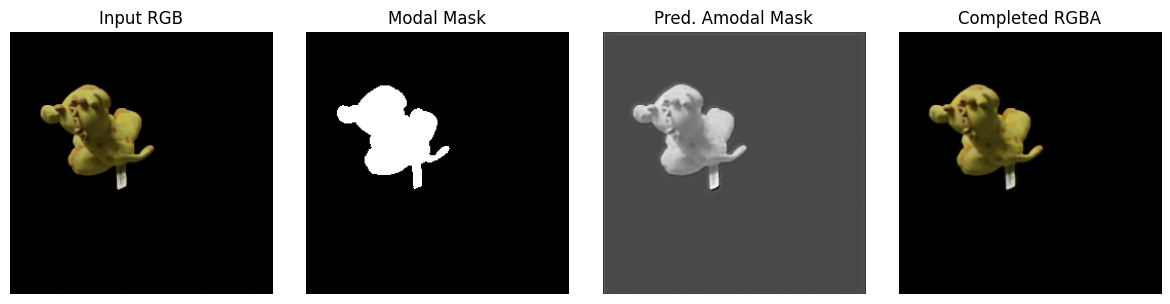

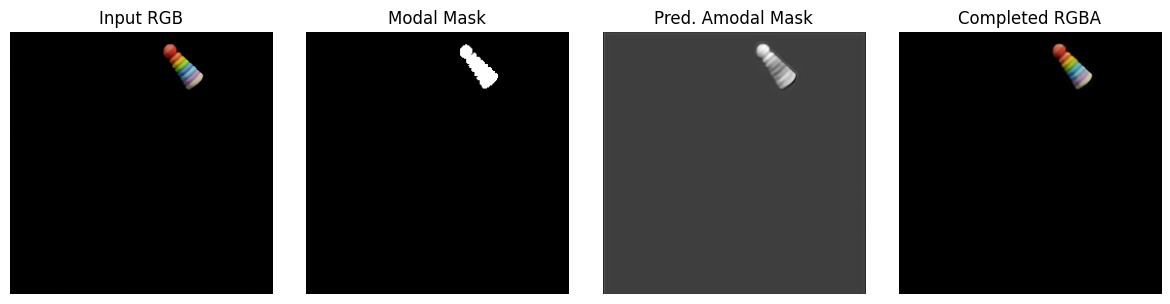

In [ ]:
#need to include rgb scene then extract modal, fixing at hotel later

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm  # added progress bar

# Dataset definition
class AmodalObjectDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        for camera in sorted(os.listdir(root_dir)):
            cam_path = os.path.join(root_dir, camera)
            if not os.path.isdir(cam_path): continue

            for obj in sorted(os.listdir(cam_path)):
                obj_path = os.path.join(cam_path, obj)
                if not os.path.isdir(obj_path): continue

                rgba_files = sorted([f for f in os.listdir(obj_path) if f.startswith('rgba_') and f.endswith('.png')])
                for rgba_file in rgba_files:
                    index = rgba_file.split('_')[-1].split('.')[0]
                    seg_file = f"segmentation_{index}.png"
                    rgba_path = os.path.join(obj_path, rgba_file)
                    seg_path = os.path.join(obj_path, seg_file)

                    if os.path.exists(seg_path):
                        self.samples.append((rgba_path, seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rgba_path, seg_path = self.samples[idx]

        rgba_image = Image.open(rgba_path).convert("RGBA")
        seg_image = Image.open(seg_path).convert("L")

        rgba_tensor = transforms.ToTensor()(rgba_image)  # (4, H, W)
        seg_tensor = transforms.ToTensor()(seg_image)    # (1, H, W)

        input_tensor = torch.cat([rgba_tensor, seg_tensor], dim=0)  # (5, H, W)

        return input_tensor, rgba_tensor  # output will be compared with original RGBA

# Model definition
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 5, kernel_size=1)  # 1 channel for amodal mask + 4 for RGBA
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# Training setup
root_dir = '/content/drive/MyDrive/colab_data/ff5da6d6ecae486bb294aeaf5ee8f8a1'
dataset = AmodalObjectDataset(root_dir)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)  # num_workers=0 for Colab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for i, (inputs, targets) in enumerate(tqdm(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        pred_rgba = outputs[:, 1:, :, :]
        loss = criterion(pred_rgba, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Loss: {running_loss:.4f}")

#in here can include evaluation metrics for performance

# Sample output visualization
inputs, targets = next(iter(dataloader))
model.eval()
with torch.no_grad():
    inputs = inputs.to(device)
    outputs = model(inputs)
    pred_mask = torch.sigmoid(outputs[:, 0:1, :, :])
    pred_rgba = torch.clamp(outputs[:, 1:, :, :], 0, 1)

    for i in range(min(2, inputs.size(0))):
        fig, axs = plt.subplots(1, 4, figsize=(12, 3))
        axs[0].imshow(inputs[i, :3].permute(1, 2, 0).cpu())
        axs[0].set_title('Input RGB')
        axs[1].imshow(inputs[i, 4].cpu(), cmap='gray')
        axs[1].set_title('Modal Mask')
        axs[2].imshow(pred_mask[i, 0].cpu(), cmap='gray')
        axs[2].set_title('Pred. Amodal Mask')
        axs[3].imshow(pred_rgba[i].permute(1, 2, 0).cpu())
        axs[3].set_title('Completed RGBA')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import os

def visualize_pipeline(model, device):
    model.eval()

    dataset_root = "/content/drive/MyDrive/colab_data/ff5da6d6ecae486bb294aeaf5ee8f8a1"
    camera_folders = [os.path.join(dataset_root, d) for d in os.listdir(dataset_root) if d.startswith("camera_")]
    random_camera = random.choice(camera_folders)

    obj_folders = [os.path.join(random_camera, d) for d in os.listdir(random_camera) if d.startswith("obj_")]
    random_obj = random.choice(obj_folders)

    idx = random.randint(0, 23)
    obj_rgba_path = os.path.join(random_obj, f"rgba_{idx:05d}.png")     # Only the object itself
    scene_rgba_path = os.path.join(random_camera, f"rgba_{idx:05d}.png")  # Full scene RGBA

    seg_path = os.path.join(random_obj, f"segmentation_{idx:05d}.png")

    # Load object RGBA image and modal segmentation
    rgba_image = Image.open(obj_rgba_path).convert("RGBA")
    seg_image = Image.open(seg_path).convert("L")
    seg_array = np.array(seg_image)

    # Modal mask: just the object of interest
    modal_mask = (seg_array > 0).astype(np.uint8)

    # Full scene segmentation: combine all objects in the camera folder
    all_seg_paths = []
    for obj in obj_folders:
        other_seg = os.path.join(obj, f"segmentation_{idx:05d}.png")
        if os.path.exists(other_seg):
            all_seg_paths.append(other_seg)

    full_scene_seg = np.zeros_like(seg_array)
    for path in all_seg_paths:
        arr = np.array(Image.open(path).convert("L"))
        full_scene_seg = np.maximum(full_scene_seg, arr)

    # Input transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    input_tensor = transform(rgba_image).unsqueeze(0).to(device)
    modal_tensor = torch.from_numpy(modal_mask).unsqueeze(0).unsqueeze(0).float().to(device)

    # Predict amodal mask
    with torch.no_grad():
        output = model(input_tensor, modal_tensor)
        if isinstance(output, tuple):
            output = output[0]
        pred_amodal = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_amodal = (pred_amodal > 0.5).astype(np.uint8)

    # Colorized amodal using object RGB
    rgba_np = np.array(rgba_image)
    rgb_np = rgba_np[:, :, :3]
    colorized_amodal = np.zeros_like(rgb_np)
    for c in range(3):
        colorized_amodal[:, :, c] = rgb_np[:, :, c] * pred_amodal

    # Load full scene RGB (not just the object)
    full_scene_image = Image.open(scene_rgba_path).convert("RGB")

    # Plot results
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))

    axs[0].imshow(full_scene_image)
    axs[0].set_title("Original RGB Scene (All Objects)")

    axs[1].imshow(full_scene_seg, cmap='gray')
    axs[1].set_title("Full Scene Segmentation")

    axs[2].imshow(modal_mask, cmap='gray')
    axs[2].set_title("Modal Mask of Selected Object")

    axs[3].imshow(pred_amodal, cmap='gray')
    axs[3].set_title("Predicted Amodal Mask")

    axs[4].imshow(colorized_amodal)
    axs[4].set_title("Colorized Amodal Prediction")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


visualize_pipeline(model, device)

TypeError: SimpleUNet.forward() takes 2 positional arguments but 3 were given

---

### Task 2.1: (Video-based) Modal Mask -> Amodal Mask

> "Given a video of the modal mask of an object, predict the amodal mask of the same object"

Inputs:
- RGB Frames
  - N 3-channel images (N, 3, 256, 256)
- N Modal Masks of Object *i*
  - N Binary (1-channel) images (N, 1, 256, 256)

Outputs:
- N Amodal Masks of Object *i*
  - N Binary (1-channel) images (1, 256, 256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import random

# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Reuse the same loss function from Task 1.1
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, pred, target):
        smooth = 1e-5
        intersection = (pred * target).sum(dim=(-2,-1))  # Handle batch and sequence dims
        union = pred.sum(dim=(-2,-1)) + target.sum(dim=(-2,-1))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        # pred and target shapes: (batch_size, seq_len, 1, H, W)
        bce = F.binary_cross_entropy(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

# Video Dataset Class
class VideoModalAmodalDataset(Dataset):
    def __init__(self, root_dir, sequence_length=8, transform=None, camera_folders=None, stride=4):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.stride = stride  # Skip frames to get temporal diversity
        self.transform = transform
        self.samples = []

        # Get all camera folders or use specified ones
        if camera_folders is None:
            camera_folders = [f for f in os.listdir(root_dir) if f.startswith('camera_')]

        print(f"Processing {len(camera_folders)} camera folders for video sequences...")

        for camera_folder in camera_folders:
            camera_path = os.path.join(root_dir, camera_folder)
            if not os.path.exists(camera_path):
                continue

            # Get base RGB images and segmentation masks
            base_rgb_files = sorted([f for f in os.listdir(camera_path) if f.startswith('rgba_')])
            base_seg_files = sorted([f for f in os.listdir(camera_path) if f.startswith('segmentation_')])

            # Get object folders
            obj_folders = sorted([f for f in os.listdir(camera_path) if f.startswith('obj_')])

            # Create sequences for each object
            for obj_folder in obj_folders:
                obj_id = int(obj_folder.split('_')[1])
                obj_path = os.path.join(camera_path, obj_folder)

                # Create sequences with stride
                max_start_frame = len(base_rgb_files) - (sequence_length * stride)

                for start_idx in range(0, max_start_frame + 1, stride):
                    sequence_frames = []
                    valid_sequence = True

                    # Check if all frames in sequence exist
                    for i in range(sequence_length):
                        frame_idx = start_idx + (i * stride)
                        if frame_idx >= len(base_rgb_files):
                            valid_sequence = False
                            break

                        frame_number = base_rgb_files[frame_idx].split('_')[1].split('.')[0]

                        # Check if all required files exist for this frame
                        rgb_path = os.path.join(camera_path, base_rgb_files[frame_idx])
                        modal_path = os.path.join(camera_path, base_seg_files[frame_idx])
                        amodal_path = os.path.join(obj_path, f'segmentation_{frame_number}.png')

                        if not all(os.path.exists(p) for p in [rgb_path, modal_path, amodal_path]):
                            valid_sequence = False
                            break

                        sequence_frames.append({
                            'rgb_path': rgb_path,
                            'modal_mask_path': modal_path,
                            'amodal_mask_path': amodal_path,
                            'frame_number': frame_number
                        })

                    if valid_sequence:
                        self.samples.append({
                            'sequence': sequence_frames,
                            'object_id': obj_id,
                            'camera': camera_folder,
                            'start_frame': start_idx
                        })

        print(f"Created {len(self.samples)} video sequences")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        rgb_sequence = []
        modal_sequence = []
        amodal_sequence = []

        try:
            for frame_info in sample['sequence']:
                # Load RGB image
                rgb_img = Image.open(frame_info['rgb_path']).convert('RGB')
                rgb_img = rgb_img.resize((256, 256), Image.BILINEAR)

                # Load and process modal mask
                modal_seg = Image.open(frame_info['modal_mask_path'])
                modal_array = np.array(modal_seg)
                modal_mask = (modal_array == sample['object_id']).astype(np.uint8)
                modal_mask = Image.fromarray(modal_mask * 255).resize((256, 256), Image.NEAREST)

                # Load amodal mask
                amodal_mask = Image.open(frame_info['amodal_mask_path']).convert('L')
                amodal_array = np.array(amodal_mask)
                amodal_mask = Image.fromarray((amodal_array > 0).astype(np.uint8) * 255)
                amodal_mask = amodal_mask.resize((256, 256), Image.NEAREST)

                # Apply transforms
                if self.transform:
                    # Apply same random transform to all frames in sequence
                    seed = np.random.randint(2147483647)

                    random.seed(seed)
                    torch.manual_seed(seed)
                    rgb_img = self.transform(rgb_img)

                    random.seed(seed)
                    torch.manual_seed(seed)
                    modal_mask = transforms.ToTensor()(modal_mask)

                    random.seed(seed)
                    torch.manual_seed(seed)
                    amodal_mask = transforms.ToTensor()(amodal_mask)
                else:
                    rgb_img = transforms.ToTensor()(rgb_img)
                    modal_mask = transforms.ToTensor()(modal_mask)
                    amodal_mask = transforms.ToTensor()(amodal_mask)

                # Ensure masks are binary
                modal_mask = (modal_mask > 0.5).float()
                amodal_mask = (amodal_mask > 0.5).float()

                rgb_sequence.append(rgb_img)
                modal_sequence.append(modal_mask)
                amodal_sequence.append(amodal_mask)

            # Stack sequences: (seq_len, channels, H, W)
            rgb_sequence = torch.stack(rgb_sequence)
            modal_sequence = torch.stack(modal_sequence)
            amodal_sequence = torch.stack(amodal_sequence)

            return {
                'rgb_sequence': rgb_sequence,
                'modal_sequence': modal_sequence,
                'amodal_sequence': amodal_sequence,
                'object_id': sample['object_id'],
                'camera': sample['camera']
            }

        except Exception as e:
            print(f"Error loading sequence {idx}: {e}")
            # Return dummy sequence
            seq_len = self.sequence_length
            return {
                'rgb_sequence': torch.zeros(seq_len, 3, 256, 256),
                'modal_sequence': torch.zeros(seq_len, 1, 256, 256),
                'amodal_sequence': torch.zeros(seq_len, 1, 256, 256),
                'object_id': 0,
                'camera': 'camera_0000'
            }

# Simple ConvLSTM Cell
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        super().__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        padding = kernel_size // 2

        self.conv = nn.Conv2d(
            input_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        combined_conv = self.conv(combined)

        i, f, o, g = torch.split(combined_conv, self.hidden_channels, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c

# Video U-Net with ConvLSTM
class VideoUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (reuse from Task 1.1)
        self.enc1 = self._make_layer(4, 64)    # 4 channels: 3 RGB + 1 modal mask
        self.enc2 = self._make_layer(64, 128)
        self.enc3 = self._make_layer(128, 256)
        self.enc4 = self._make_layer(256, 512)

        # ConvLSTM for temporal modeling at bottleneck
        self.conv_lstm = ConvLSTMCell(512, 512, kernel_size=3)

        # Decoder
        self.dec3 = self._make_layer(512 + 256, 256)
        self.dec2 = self._make_layer(256 + 128, 128)
        self.dec1 = self._make_layer(128 + 64, 64)

        # Final layers
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout2d(0.3)
        self.pool = nn.MaxPool2d(2)

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, 4, H, W)
        batch_size, seq_len, channels, height, width = x.shape

        outputs = []
        h_state = None
        c_state = None

        for t in range(seq_len):
            # Current frame
            frame = x[:, t]  # (batch_size, 4, H, W)

            # Encoder
            e1 = self.enc1(frame)
            e2 = self.enc2(self.pool(e1))
            e3 = self.enc3(self.pool(e2))
            e4 = self.enc4(self.pool(e3))

            # Apply dropout
            e4 = self.dropout(e4)

            # ConvLSTM for temporal modeling
            if h_state is None:
                h_state = torch.zeros_like(e4)
                c_state = torch.zeros_like(e4)

            h_state, c_state = self.conv_lstm(e4, h_state, c_state)

            # Decoder with skip connections (using current frame's encoder features)
            d3 = self.dec3(torch.cat([F.interpolate(h_state, size=e3.shape[2:], mode='bilinear', align_corners=True), e3], dim=1))
            d2 = self.dec2(torch.cat([F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True), e2], dim=1))
            d1 = self.dec1(torch.cat([F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True), e1], dim=1))

            output = self.final(d1)
            outputs.append(output)

        # Stack outputs: (batch_size, seq_len, 1, H, W)
        return torch.stack(outputs, dim=1)

def train_video_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch in train_pbar:
            rgb_seq = batch['rgb_sequence'].to(device)
            modal_seq = batch['modal_sequence'].to(device)
            amodal_seq = batch['amodal_sequence'].to(device)

            # Concatenate RGB and modal mask
            x = torch.cat([rgb_seq, modal_seq], dim=2)  # (batch, seq_len, 4, H, W)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, amodal_seq)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch in val_pbar:
                rgb_seq = batch['rgb_sequence'].to(device)
                modal_seq = batch['modal_sequence'].to(device)
                amodal_seq = batch['amodal_sequence'].to(device)

                x = torch.cat([rgb_seq, modal_seq], dim=2)
                output = model(x)
                loss = criterion(output, amodal_seq)

                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f'💾 Saving best model with validation loss: {best_val_loss:.4f}')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_video_model.pth')

    return history

def visualize_video_results(model, data_loader, device, num_sequences=3):
    model.eval()
    sequences_shown = 0

    with torch.no_grad():
        for batch in data_loader:
            if sequences_shown >= num_sequences:
                break

            rgb_seq = batch['rgb_sequence'].to(device)
            modal_seq = batch['modal_sequence'].to(device)
            amodal_seq = batch['amodal_sequence'].to(device)

            x = torch.cat([rgb_seq, modal_seq], dim=2)
            pred_seq = model(x)

            # Show first sequence in batch
            rgb_seq = rgb_seq[0].cpu()
            modal_seq = modal_seq[0].cpu()
            amodal_seq = amodal_seq[0].cpu()
            pred_seq = pred_seq[0].cpu()

            seq_len = rgb_seq.shape[0]

            fig, axes = plt.subplots(4, seq_len, figsize=(3*seq_len, 12))

            for t in range(seq_len):
                # RGB Frame
                rgb_display = rgb_seq[t].permute(1, 2, 0)
                rgb_display = torch.clamp(rgb_display, 0, 1)
                axes[0, t].imshow(rgb_display)
                axes[0, t].set_title(f'RGB Frame {t+1}')
                axes[0, t].axis('off')

                # Modal Mask
                axes[1, t].imshow(modal_seq[t, 0], cmap='gray', vmin=0, vmax=1)
                axes[1, t].set_title(f'Modal Mask {t+1}')
                axes[1, t].axis('off')

                # Ground Truth Amodal
                axes[2, t].imshow(amodal_seq[t, 0], cmap='gray', vmin=0, vmax=1)
                axes[2, t].set_title(f'GT Amodal {t+1}')
                axes[2, t].axis('off')

                # Predicted Amodal
                axes[3, t].imshow(pred_seq[t, 0], cmap='gray', vmin=0, vmax=1)
                axes[3, t].set_title(f'Pred Amodal {t+1}')
                axes[3, t].axis('off')

            plt.tight_layout()
            plt.show()

            sequences_shown += 1

def main():
    # Set seeds
    set_seeds(42)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Define transforms with light augmentation for videos
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),  # Reduced for temporal consistency
        transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Light augmentation
        transforms.ToTensor(),
    ])

    # Create video dataset
    dataset_path = '/content/drive/MyDrive/DSC2025/ff5da6d6ecae486bb294aeaf5ee8f8a1'  # Update path

    # Use shorter sequences and larger stride for efficiency
    full_dataset = VideoModalAmodalDataset(
        root_dir=dataset_path,
        sequence_length=6,  # 6 frames per sequence
        stride=2,           # Skip every other frame
        transform=transform
    )

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders with smaller batch size due to video sequences
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,  # Smaller batch size for video
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Video dataset splits:")
    print(f"Training set size: {len(train_dataset)} sequences")
    print(f"Validation set size: {len(val_dataset)} sequences")
    print(f"Test set size: {len(test_dataset)} sequences")

    # Initialize model
    model = VideoUNet().to(device)

    # Define loss function and optimizer
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Train the model
    history = train_video_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=15,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Video Training History')
    plt.legend()
    plt.show()

    # Visualize results
    print("\nVisualizing video results...")
    visualize_video_results(model, test_loader, device, num_sequences=2)

if __name__ == "__main__":
    main()

Using device: cuda
Processing 6 camera folders for video sequences...
Created 703 video sequences
Video dataset splits:
Training set size: 492 sequences
Validation set size: 105 sequences
Test set size: 106 sequences


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15 [Val]: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it, loss=0.5918]



Epoch 1/15:
Training Loss: 0.6010
Validation Loss: 0.5469
--------------------------------------------------
💾 Saving best model with validation loss: 0.5469


Epoch 2/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, loss=0.5319]



Epoch 2/15:
Training Loss: 0.5198
Validation Loss: 0.4764
--------------------------------------------------
💾 Saving best model with validation loss: 0.4764


Epoch 3/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, loss=0.4797]



Epoch 3/15:
Training Loss: 0.4577
Validation Loss: 0.4179
--------------------------------------------------
💾 Saving best model with validation loss: 0.4179


Epoch 4/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s, loss=0.4403]



Epoch 4/15:
Training Loss: 0.3984
Validation Loss: 0.3634
--------------------------------------------------
💾 Saving best model with validation loss: 0.3634


Epoch 5/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  4.01it/s, loss=0.3428]



Epoch 5/15:
Training Loss: 0.3414
Validation Loss: 0.2956
--------------------------------------------------
💾 Saving best model with validation loss: 0.2956


Epoch 6/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, loss=0.2848]



Epoch 6/15:
Training Loss: 0.2831
Validation Loss: 0.2378
--------------------------------------------------
💾 Saving best model with validation loss: 0.2378


Epoch 7/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  4.01it/s, loss=0.2087]



Epoch 7/15:
Training Loss: 0.2328
Validation Loss: 0.1981
--------------------------------------------------
💾 Saving best model with validation loss: 0.1981


Epoch 8/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.97it/s, loss=0.1524]



Epoch 8/15:
Training Loss: 0.1984
Validation Loss: 0.1637
--------------------------------------------------
💾 Saving best model with validation loss: 0.1637


Epoch 9/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  4.00it/s, loss=0.1544]



Epoch 9/15:
Training Loss: 0.1734
Validation Loss: 0.1483
--------------------------------------------------
💾 Saving best model with validation loss: 0.1483


Epoch 10/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, loss=0.1532]



Epoch 10/15:
Training Loss: 0.1520
Validation Loss: 0.1359
--------------------------------------------------
💾 Saving best model with validation loss: 0.1359


Epoch 11/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s, loss=0.0946]



Epoch 11/15:
Training Loss: 0.1461
Validation Loss: 0.1188
--------------------------------------------------
💾 Saving best model with validation loss: 0.1188


Epoch 12/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  4.00it/s, loss=0.0867]



Epoch 12/15:
Training Loss: 0.1353
Validation Loss: 0.1168
--------------------------------------------------
💾 Saving best model with validation loss: 0.1168


Epoch 13/15 [Val]: 100%|██████████| 27/27 [00:06<00:00,  3.96it/s, loss=0.0614]



Epoch 13/15:
Training Loss: 0.1316
Validation Loss: 0.1116
--------------------------------------------------
💾 Saving best model with validation loss: 0.1116


Epoch 14/15 [Train]:  88%|████████▊ | 108/123 [01:25<00:11,  1.28it/s, loss=0.1572]

---

### Task 2.2: (Video-based) Modal Content (RGB) -> Amodal Content (RGB)

> "Given a video of the modal RGB content of an object, predict the amodal RGB content of the same object"

> "Can use the amodal masks of that object"

Inputs:
- N RGB Frames
  - N 3-channel images (N, 3, 256, 256)
- N Amodal Masks of Object *i*
  - N Binary (1-channel) images (N, 1, 256, 256)
- N RGB Contents of Object *i*
  - N 3-channel images (N, 3, 256, 256)
  - Use the object's modal mask to "crop out" the RGB content of object *i*
  - Optional to use?
  
Outputs:
- N Amodal RGB Contents of Object *i*
  - N 3-channel images (N, 3, 256, 256)

---

### Bonus Task 3: Create Modal Masks with SAM2

> "Run SAM2 on the <u>**Robotics Laboratory Pick and Place Dataset**</u> and make your own modal masks!"
- https://github.com/facebookresearch/sam2

Inputs:
- Video
- For the object of interest: clickable points, bounding boxes, masks

Output:
- Masklet (Object masks across the video)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#put a mount here because i got tired of scrolling up

Mounted at /content/drive


In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    #!{sys.executable} -m pip install opencv-python matplotlib
    #!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    # Add video link here:
    !unzip -d videos VialsWithColor_Every10th_Subset.mp4

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
--2025-07-21 18:56:26--  https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12688166 (12M) [application/zip]
Saving to: ‘videos/bedroom.zip.1’

bedroom.zip.1       100%[===================>]  12.10M  --.-KB/s    in 0.07s   

2025-07-21 18:56:26 (163 MB/s) - ‘videos/bedroom.zip.1’ saved [12688166/12688166]

unzip:  cannot find or open VialsWithColor_Every10th_Subset.mp4, VialsWithColor_Every10th_Subset.mp4.zip or VialsWithColor_Every10th_Subset.mp4.ZIP.
--2025-07-21 18:56:27--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    #this makes my thing explode use float16 instead of bfloat16
    torch.autocast("cuda", dtype=torch.float16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 37.57 MiB/s, done.
Resolving deltas: 100% (380/380), done.


In [ ]:
%cd sam2

/content/sam2


In [ ]:
!pip install -e .

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
 

In [ ]:
!pip install -e ".[notebooks]"

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.9 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp311-cp311-lin

In [ ]:
%cd /content/sam2/checkpoints
!chmod +x download_ckpts.sh
!./download_ckpts.sh
%cd ..

/content/sam2/checkpoints
--2025-07-21 18:54:25--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.102, 18.154.144.74, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   241MB/s    in 0.6s    

2025-07-21 18:54:26 (241 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-07-21 18:54:26--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.102, 18.154.144.74, 18.154.144.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.102|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
import sam2

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/content/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
# check path and move to where stuff is stored

import os
os.chdir("/content/drive/MyDrive/colab_data")  # change this with your file location
print(os.getcwd())  # confirms directory

/content/drive/MyDrive/colab_data


In [ ]:
# checks if .mp4 file is in above directory
!ls

ff5da6d6ecae486bb294aeaf5ee8f8a1
ff5da6d6ecae486bb294aeaf5ee8f8a1.tar.gz
frames
mask5_vialswithcolor_every10th_subset.pt
output_frames
output_masked_video1.mp4
output_masked_video.mp4
VialsWithColor_Every10th_Subset
VialsWithColor_Every10th_Subset.mp4
VialsWithColor_Every10th_Subset.tar.gz


In [ ]:
# create frames folder/directory:
!mkdir -p frames
# run this once, then dont need to run again since it'll be created within your mounted drive

In [ ]:
# sanity check for frames folder/directory

import os

if os.path.exists("frames"):
    print("✅ 'frames/' directory exists.")
else:
    print("❌ 'frames/' directory does NOT exist.")

✅ 'frames/' directory exists.


In [ ]:
# Since we have a video:

!ffmpeg -i VialsWithColor_Every10th_Subset.mp4 -q:v 2 -start_number 0 frames/'%05d.jpg'

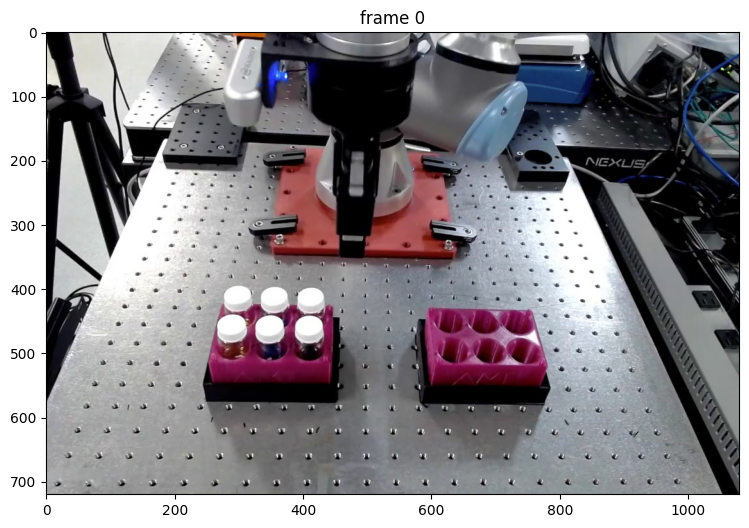

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)
# this line is the RAM killer, be sure to be on a runtime with high RAM (i use L4)
# also has high chance to crash runtime

frame loading (JPEG): 100%|██████████| 700/700 [00:25<00:00, 26.99it/s]


In [ ]:
# something to use before previous line if necessary
predictor.reset_state(inference_state)
# if doing multiple runs, run this block so that it resets above variable so it can be run again with any changes to code before it

In [ ]:
# check how many frames are in the video:
import cv2

cap = cv2.VideoCapture("/content/drive/MyDrive/colab_data/VialsWithColor_Every10th_Subset.mp4")  # replace with your video file path

if not cap.isOpened():
    print("Error opening video file")
else:
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames: {total_frames}")

cap.release()

Total number of frames: 700


/content/sam2/sam2/sam2_video_predictor.py:786: UserWarning: /content/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


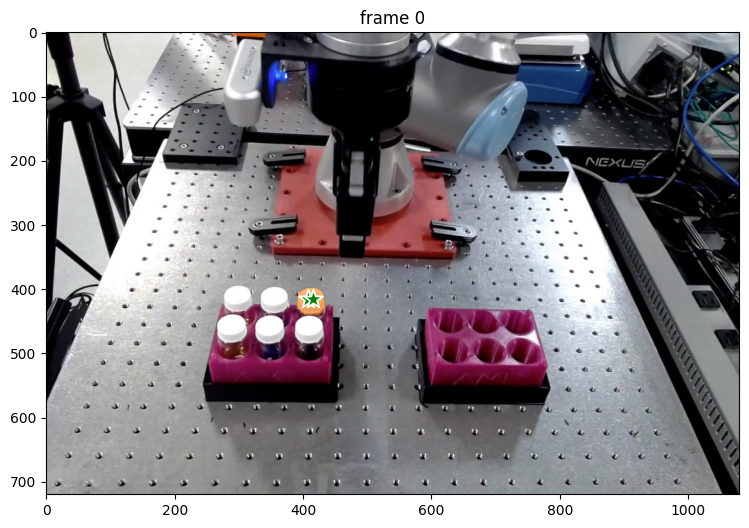

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integer)

# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[407, 415], [415, 415]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

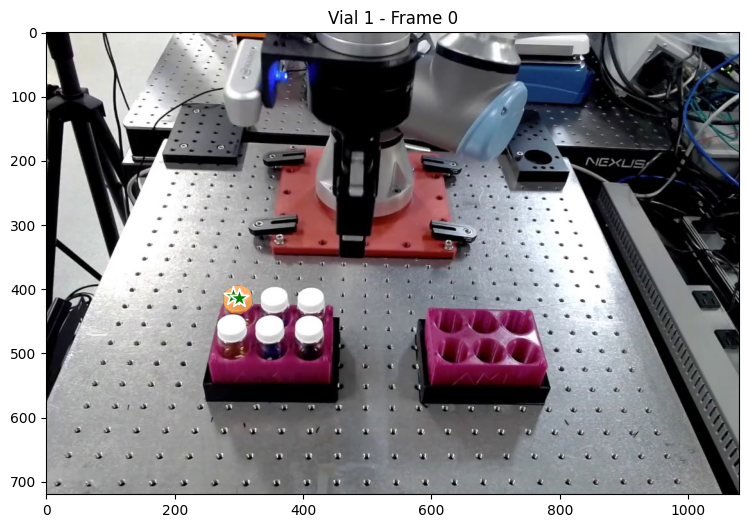

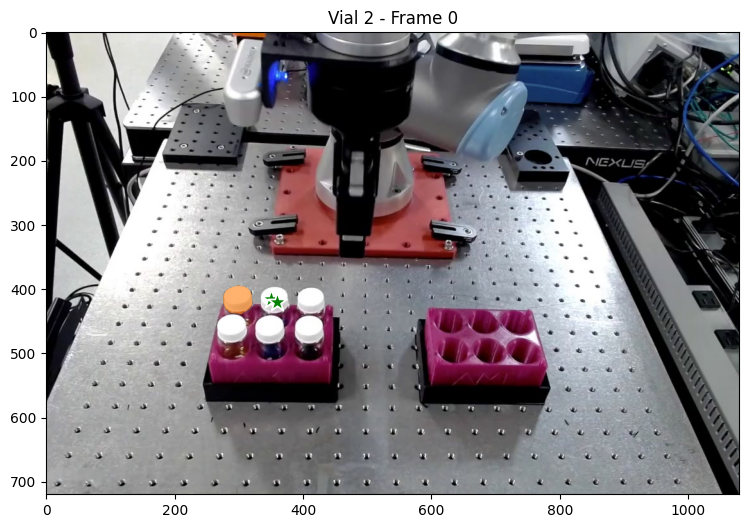

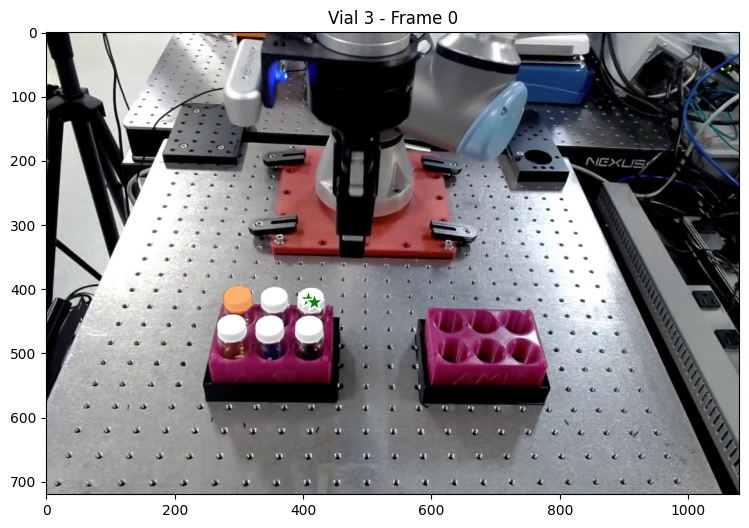

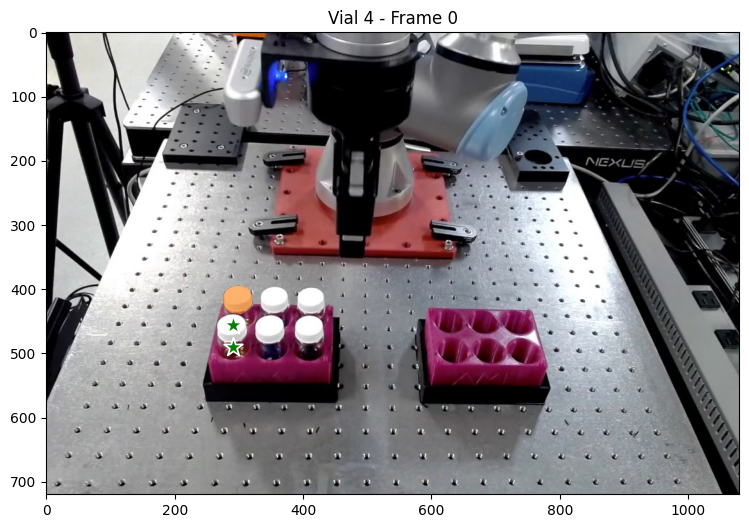

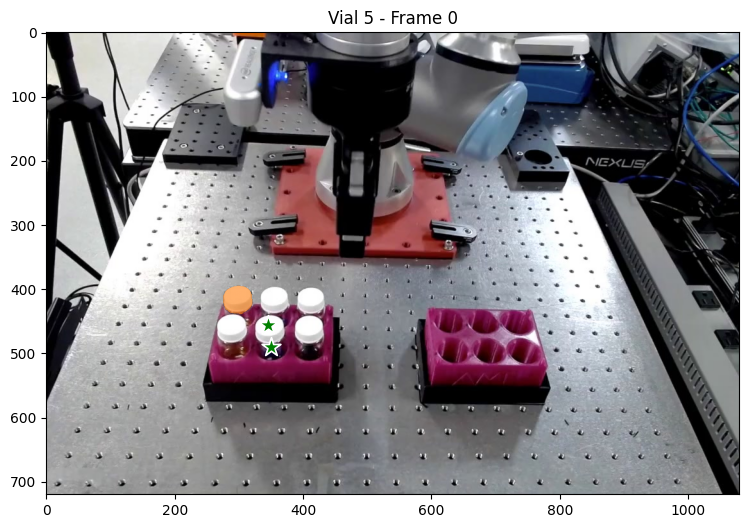

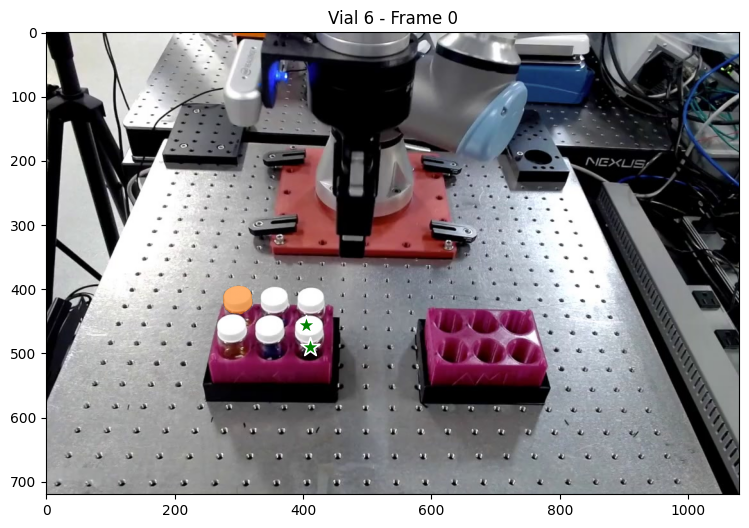

In [ ]:

ann_frame_idx = 0  # frame for all annotations

# should change the coords here on array 3
# if 407 and 415, difference should try being 10 cords, do new 407 and 417
# define all 6 vials with unique obj_id and placeholder points
vial_annotations = {
    1: np.array([[290, 410], [300, 413]], dtype=np.float32), # Top left
    2: np.array([[350, 415], [360, 420]], dtype=np.float32), # Top middle
    3: np.array([[407, 415], [417, 420]], dtype=np.float32), # Top right
    4: np.array([[290, 490], [290, 455]], dtype=np.float32), # Bottom left
    5: np.array([[350, 490], [345, 455]], dtype=np.float32), # Bottom middle
    6: np.array([[410, 490], [405, 455]], dtype=np.float32), # Bottom right
}

# add all vials to the inference state
for obj_id, points in vial_annotations.items():
    labels = np.array([1, 1], dtype=np.int32)  # both positive clicks
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=obj_id,
        points=points,
        labels=labels,
    )

    # Visualize annotation (optional)
    plt.figure(figsize=(9, 6))
    plt.title(f"Vial {obj_id} - Frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


In [ ]:
# this begins stitching the frames together to create video, also begins tracking each vial for each obj_id

video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# counts how many frames each vial was found in (sanity check)
for obj_id in vial_annotations:
    count = sum(obj_id in video_segments[f] for f in video_segments)
    print(f"✅ Vial {obj_id} tracked in {count} frames.")


propagate in video: 100%|██████████| 700/700 [02:32<00:00,  4.58it/s]

✅ Vial 1 tracked in 700 frames.
✅ Vial 2 tracked in 700 frames.
✅ Vial 3 tracked in 700 frames.
✅ Vial 4 tracked in 700 frames.
✅ Vial 5 tracked in 700 frames.
✅ Vial 6 tracked in 700 frames.


In [ ]:
# another sanity check: counts how many frames got masks (sanity checked twice and tracking is still wrong :D )
masked_count = sum(ann_obj_id in frame for frame in video_segments.values())
print(f"Masks applied to {masked_count} frames out of {len(frame_names)} total.")


Masks applied to 700 frames out of 700 total.


In [ ]:

output_dir = "output_frames"
os.makedirs(output_dir, exist_ok=True)

for frame_idx in range(len(frame_names)):
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    img = np.array(Image.open(frame_path).convert("RGB"))

    if frame_idx in video_segments:
        for obj_id in vial_annotations:
            if obj_id in video_segments[frame_idx]:
                mask = video_segments[frame_idx][obj_id]

                if mask.ndim == 3 and mask.shape[0] == 1:
                    mask = mask[0]
                if mask.shape != img.shape[:2]:
                    mask = cv2.resize(mask.astype(np.uint8), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                else:
                    mask = mask.astype(np.uint8)

                # overlay mask
                colored_mask = np.zeros_like(img)
                mask_bool = mask.astype(bool)
                color = [int(c) for c in np.random.RandomState(obj_id).randint(100, 256, size=3)]
                colored_mask[mask_bool] = color
                img = cv2.addWeighted(img, 1.0, colored_mask, 0.5, 0)

                # bounding box + label
                x, y, w, h = cv2.boundingRect(mask)
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                cv2.putText(img, f"Vial {obj_id}", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    out_path = os.path.join(output_dir, f"{frame_idx:05d}.png")
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


In [ ]:
!ffmpeg -framerate 30 -i output_frames/%05d.png -c:v libx264 -pix_fmt yuv420p output_masked_video2.mp4
# gives the video with tracked and boxes as a saved video in directory on colab

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
from google.colab import files
files.download("output_masked_video2.mp4")
#use this block to download the above video to have it saved onto computer and then check the results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

### Bonus Task 4: Re-ID of Objects

> "Given 2 objects, are they the same?"

> "Given an object, retrieve similar objects from a catalog of objects"

Inputs:
- Image or Video data?
- Modal or Amodal data?
- Masks, RGB Content?
  
Outputs:
- Are the 2 objects the same?
- Retrieved similar objects A, B, C, given object X?

---

# End

Have fun!

# More advanced examples/extra material

### Utils

In [ ]:

def calculate_metrics(amodal_mask_preds,
                      amodal_mask_labels,
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


### Dataset

#### Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
import torch
from PIL import Image
import numpy as np
import random

class MOVi_Dataset(Dataset):
    def __init__(self, split = 'train' or 'test',
                 n_frames = 8,
                 n_samples = 1000,
                 #box_format = 'xywh'
                 ):
        print('Dataset init on', split)

        self.split = split
        self.top_dir = f'/data1/Video/CVP/data/MOVi-MC-AC/{split}/'
        print('Init data top dir:', self.top_dir)

        #self.box_format = box_format

        # Get directories in data_dir/train-test
        self.scenes = [entry for entry in os.listdir(self.top_dir) if os.path.isdir(os.path.join(self.top_dir, entry))]

        self.n_frames = n_frames
        self.n_samples = n_samples

    def __len__(self):
        # In theory this could be like n_scenes*n_objects
        # To get total number of (cam-invariant) objects
        return self.n_samples

    def load_cam_frames(self, scene,
                    cam_idx,
                    start, stop,
                    modality):
        """
        One load-frames loads camera-level stuff (rgb, depth)
        The other one loads object-level stuff (scene/cam/obj_i/amodal_mask or content)
        """
        # Load frame range
        imgs = []
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            # loads train/scene_id/cam_id/frames_or_depth_or_modal/frame_id.png
            if modality == 'modal_masks':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/segmentation_{str(i).zfill(5)}{suffix}'

            if modality == 'rgba_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/rgba_{str(i).zfill(5)}{suffix}'

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/depth_{str(i).zfill(5)}.tiff'

            tens = totensor(Image.open(load_file))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)

        return tensor

    def load_obj_frames(self, scene,
                    cam_idx,
                    object_idx,
                    start, stop,
                    modality):
        """
        This loaded loads object-level stuff
        """
        # Load frame range
        imgs = []
        # amodal_segs, content, rgba_full, modal_masks, depth_full
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            if modality == 'amodal_segs':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))

            if modality == 'content':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)
        return tensor


    def __getitem__(self, idx):
        # Select a random sample
        random_scene = np.random.choice(self.scenes)

        # Get the list of objects in that sample
        all_object_ids = self.all_objects(self.top_dir + random_scene + '/camera_0000/' )

        # Pick a random object
        target_object_id = np.random.choice(all_object_ids)

        """
        Loading from multiple cameras in parallel:
        """

        # Make these random
        start = random.randint(0, 24-self.n_frames)
        stop = start+self.n_frames

        i = random.randint(0, 5)
        frames, depths, modal_masks, amodal_segs, amodal_content = self.load_camera(random_scene, cam_id = f'camera_{str(i).zfill(4)}', obj_id = target_object_id, start = start, stop = stop)

        modal_masks = modal_masks*255
        modal_masks = modal_masks.to(torch.uint8)
        sample = {
            'frames': frames,
            'depths': depths,
            'modal_masks': modal_masks,
            'amodal_masks': amodal_segs,
            'amodal_content': amodal_content,
        }
        return sample


    def load_camera(self, scene_id, cam_id, obj_id, start, stop):

        # Load the target objects
        modal_segs = self.load_cam_frames(scene_id,
                                            cam_id,
                                            start, stop,
                                            'modal_masks')

        modal_segs = modal_segs*255
        modal_segs = modal_segs.int()

        # Load frames corresponding to inputs
        frames = self.load_cam_frames(scene_id,
                                      cam_id,
                                      start,
                                      stop,
                                      'rgba_full')[:-1]

        # Load depth (though we will have to replace with Depth-Anything-V2 estimates)
        depths = self.load_cam_frames(scene_id, cam_id, start, stop, 'depth_full')

        amodal_segs = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'amodal_segs')
        amodal_content = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'content')

        return frames, depths, modal_segs, amodal_segs, amodal_content

    def all_objects(self, pth):
        """
        Given a path, get the objects at that path using regex
        """
        #print('looking for all objects at', pth)

        # Find all matches
        matches = []
        for fname in sorted(os.listdir(pth)):
            if 'obj_' in fname:
                matches.append(fname)

        #print(matches)
        return matches # list of ['obj_0001', 'obj_0009',...]

#### Example Usage & Visualzations

In [ ]:
dataset = MOVi_Dataset(split = 'train', n_frames = 1)
sample = next(iter(dataset))

print(sample.keys())

for key, value in sample.items():
    print(key, value.shape)

Dataset init on train
Init data top dir: /data1/Video/CVP/data/MOVi-MC-AC/train/


FileNotFoundError: [Errno 2] No such file or directory: '/data1/Video/CVP/data/MOVi-MC-AC/train/'

In [ ]:

import matplotlib.pyplot as plt

x = sample['depths'][0][0]
print(x.min(), x.max())
plt.imshow(x)
plt.show()

plt.imshow(sample['frames'][:, 0].permute(1,2,0))
plt.show()


plt.imshow(sample['amodal_masks'][:, 0].permute(1,2,0))
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.show()

### Model

#### Class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)

class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()

        self.mpool_2 = nn.MaxPool2d((2, 2))

        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2)

        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)

        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)

        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4

    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)

        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content

    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w)
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content

    def forward(self, batch):
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)

        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask,
                                                        amodal_mask_labels,
                                                        logits_amodal_content,
                                                        amodal_content_labels)

        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask,
                                    amodal_mask_labels,
                                    logits_amodal_content,
                                    amodal_content_labels)

        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        return mask_loss, content_loss

#### Example Usage

In [ ]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)

# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

### Training

#### Utils

In [ ]:
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

def batch_to_device(batch, device):
    for key, value in batch.items():
        batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, train_dataloader, val_dataloader, n_epochs, device):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in range(n_epochs):
        print('Starting Epoch', epoch)
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%1 == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])

    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)



#### Train

In [ ]:
# Arguments
learning_rate = 3e-5 # 3e-4?...
batch_size = 32
mask_content_preds = True
n_workers = 32
n_epochs = 20

# Dataloaders
train_dataset = MOVi_Dataset(split = 'train',
                             n_frames = 1,
                             n_samples = 64)
train_dataloader = DataLoader(train_dataset,
                              num_workers = n_workers,
                              batch_size=batch_size)

val_dataset = MOVi_Dataset(split = 'test',
                           n_frames = 1,
                           n_samples = 32)
val_dataloader = DataLoader(train_dataset,
                            num_workers = n_workers,
                            batch_size=batch_size)


"""
Our model is a torch model which contains the layers we will train.
This model takes the RGB image and the modal mask of an object (an attention cue)
And will be trained to return the amodal (unobscured) mask as well as the amodal content.
Think of this as training for "x-ray vision" - given an attention cue, return what the unoccluded object
would look like, given hints from the image or video.

Extending this to video will be the next step, so start thinking about how you can combine
multiple frames of information to predict what an occluded object looks like.
"""

device = 0
model = Unet_Image(in_channels = 4).to(device) # ModalMask+RGB -> AmodalMask+AmodalContent

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, optim, train_dataloader, val_dataloader, n_epochs = n_epochs, device = device)

"""
While this trains, you should see the epoch performances greatly improving on the training split.
They may or may not improve on the validation split depending on many factors.
Now that this code runs though, try turning up the size of the datasets and see what affect that has.

Then eventually you can start designing a model intended to track and segment objects from video
which will require setting the datasets n_frames to a larger number, and re-designing your torch model.

Hopefully everything else remains working though! I would copy this notebook to have around for referce
Then make your own notebook where you experiment with new designs! :)
"""